In [1]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from collections import defaultdict 
from hstrat2 import hstrat
import itertools as it
import networkx as nx
from networkx.algorithms.components.connected import connected_components as nx_connected_components
import pandas as pd
import pulp
import random


In [2]:
random.seed(2)

# data generation

In [3]:
population_size = 20
ancestor = hstrat.HereditaryStratigraphicColumn(hstrat.fixed_resolution_algo.Policy(10))
pop = [ancestor.Clone() for __ in range(population_size)]

for gen in range(4000):
    pop[random.randint(0, len(pop) - 1)] = random.choice(pop).CloneDescendant()


# problem setup

In [4]:
# arbitrary large value used for linear programming hacks
# https://en.wikipedia.org/wiki/Big_M_method
big_M = 10**9


In [5]:
# surveyed taxa
taxa = [chr(ord("a") + j) for j in range(len(pop))]


In [6]:
# pairwise hard UPPER bounds for MRCA generation
# (i.e., MRCA is AT or BEFORE these bounds)
# note that node names are generated by concatenation of sorted taxa
dist = {
    ''.join(sorted([chr(ord("a") + i),chr(ord("a") + j)])) 
    : hstrat.calc_rank_of_first_retained_disparity_between(pop[i], pop[j])
    for i in range(len(pop))
    for j in range(len(pop))
    if i != j
}

err = {
    ''.join(sorted([chr(ord("a") + i),chr(ord("a") + j)])) 
    : hstrat.calc_rank_of_last_retained_commonality_between(pop[i], pop[j])
    for i in range(len(pop))
    for j in range(len(pop))
    if i != j
}

In [7]:
# all possible pairings of taxa (i.e., distances in our distance matrix)
taxa_pairs = [''.join(sorted(pair)) for pair in it.combinations(taxa, 2)]
assert set(taxa_pairs) == set(dist.keys()), "mismatch between distance matrix and taxa"


In [8]:
model = pulp.LpProblem(name='MRCA_Inference', sense=pulp.LpMaximize)


# variable setup

In [9]:
mrca_dict = {}
obj_dict = {}
#input: two leaves
def get_mrca(a, b):
    key = frozenset((a, b))
    name = ''.join(sorted(key))
    if key not in mrca_dict:
        mrca_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=dist[name],
            cat=pulp.LpInteger,
        )
        obj_dict[key] = pulp.LpVariable(
            name + 'objective',
            lowBound=0,
            upBound=err[name],
            cat=pulp.LpInteger,
        )
    
    return mrca_dict[key]


In [10]:
lt_dict = {}
# input: two leaf-pairs
def get_lt(a, b):
    assert a != b
    if a > b:
        return get_gt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_lt_{second}'
    if key not in lt_dict:
        lt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return lt_dict[key]


In [11]:
eq_dict = {}
# input: two leaf-pairs
def get_eq(a, b):
    assert a != b
    key = frozenset((a, b))
    first, second = sorted(key)
    name = f'{first}_eq_{second}'
    if key not in eq_dict:
        eq_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return eq_dict[key]


In [12]:
gt_dict = {}
# input: two leaf-pairs
def get_gt(a, b):
    assert a != b
    if a > b:
        return get_lt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_gt_{second}'
    if key not in gt_dict:
        gt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return gt_dict[key]


# constraint setup

In [13]:
# set up pairwise MRCA generation comparison variables
for xx, yy in it.combinations(taxa_pairs, 2):
    if xx < yy:
            # lookup (or generate) PuLP variables
            xx_mrca = get_mrca(*xx)
            yy_mrca = get_mrca(*yy)

            xx_eq_yy = get_eq(xx, yy)
            xx_lt_yy = get_lt(xx, yy)
            xx_gt_yy = get_gt(xx, yy)

            # lt, gt, and eq are mutually exclusive
            model += xx_lt_yy + xx_gt_yy + xx_eq_yy == 1

            # attach lt/gt to MRCA generation values
            model += -big_M * xx_lt_yy + xx_gt_yy <= (xx_mrca - yy_mrca)
            model += -big_M * xx_gt_yy + xx_lt_yy <= -(xx_mrca - yy_mrca)

# add node consolidation logic
# goal AB < AC ===> BC == AC  (if then statement)
# strategy: ab_lt_ac <= bc_eq_ac    
for x, y, z in it.permutations(taxa, 3): # why isn't this combinations?
    xy = ''.join(sorted([x, y]))
    xz = ''.join(sorted([x, z]))
    yz = ''.join(sorted([y, z]))
    
    # why isn't this get_lt?, is something backwards?
    model += get_gt(xy, xz) <= get_eq(yz, xz)


In [14]:
for key in mrca_dict:
    model += obj_dict[key] <= mrca_dict[key]

# optimization setup

In [15]:
# maximum likelihood comes from pushing generations of internal nodes as far forward as possible
model += sum(obj_dict.values())


# solve

In [16]:
model


MRCA_Inference:
MAXIMIZE
1*abobjective + 1*acobjective + 1*adobjective + 1*aeobjective + 1*afobjective + 1*agobjective + 1*ahobjective + 1*aiobjective + 1*ajobjective + 1*akobjective + 1*alobjective + 1*amobjective + 1*anobjective + 1*aoobjective + 1*apobjective + 1*aqobjective + 1*arobjective + 1*asobjective + 1*atobjective + 1*bcobjective + 1*bdobjective + 1*beobjective + 1*bfobjective + 1*bgobjective + 1*bhobjective + 1*biobjective + 1*bjobjective + 1*bkobjective + 1*blobjective + 1*bmobjective + 1*bnobjective + 1*boobjective + 1*bpobjective + 1*bqobjective + 1*brobjective + 1*bsobjective + 1*btobjective + 1*cdobjective + 1*ceobjective + 1*cfobjective + 1*cgobjective + 1*chobjective + 1*ciobjective + 1*cjobjective + 1*ckobjective + 1*clobjective + 1*cmobjective + 1*cnobjective + 1*coobjective + 1*cpobjective + 1*cqobjective + 1*crobjective + 1*csobjective + 1*ctobjective + 1*deobjective + 1*dfobjective + 1*dgobjective + 1*dhobjective + 1*diobjective + 1*djobjective + 1*dkobjective +

In [17]:
model.solve()


1

In [18]:
pulp.LpStatus[model.status]


'Optimal'

# inspect results

In [19]:
for var in mrca_dict.values():
    print(var, var.varValue)


ab 170.0
ac 170.0
ad 170.0
ae 170.0
af 170.0
ag 190.0
ah 190.0
ai 170.0
aj 170.0
ak 170.0
al 170.0
am 170.0
an 170.0
ao 170.0
ap 170.0
aq 170.0
ar 190.0
as 170.0
at 170.0
bc 190.0
bd 180.0
be 180.0
bf 190.0
bg 170.0
bh 170.0
bi 180.0
bj 180.0
bk 190.0
bl 180.0
bm 190.0
bn 190.0
bo 180.0
bp 190.0
bq 190.0
br 170.0
bs 180.0
bt 190.0
cd 180.0
ce 180.0
cf 190.0
cg 170.0
ch 170.0
ci 180.0
cj 180.0
ck 190.0
cl 180.0
cm 190.0
cn 190.0
co 180.0
cp 190.0
cq 190.0
cr 170.0
cs 180.0
ct 190.0
de 190.0
df 180.0
dg 170.0
dh 170.0
di 190.0
dj 190.0
dk 180.0
dl 190.0
dm 180.0
dn 180.0
do 190.0
dp 180.0
dq 180.0
dr 170.0
ds 190.0
dt 180.0
ef 180.0
eg 170.0
eh 170.0
ei 190.0
ej 190.0
ek 180.0
el 190.0
em 180.0
en 180.0
eo 190.0
ep 180.0
eq 180.0
er 170.0
es 190.0
et 180.0
fg 170.0
fh 170.0
fi 180.0
fj 180.0
fk 190.0
fl 180.0
fm 190.0
fn 190.0
fo 180.0
fp 190.0
fq 190.0
fr 170.0
fs 180.0
ft 190.0
gh 190.0
gi 170.0
gj 170.0
gk 170.0
gl 170.0
gm 170.0
gn 170.0
go 170.0
gp 170.0
gq 170.0
gr 190.0
gs 170.0
g

In [20]:
for key in lt_dict.keys():
    print(key)
    for var in lt_dict[key], eq_dict[key], gt_dict[key]:
        print('\t', var, var.varValue)


frozenset({'ac', 'ab'})
	 ab_lt_ac 0.0
	 ab_eq_ac 1.0
	 ab_gt_ac 0.0
frozenset({'ad', 'ab'})
	 ab_lt_ad 0.0
	 ab_eq_ad 1.0
	 ab_gt_ad 0.0
frozenset({'ae', 'ab'})
	 ab_lt_ae 0.0
	 ab_eq_ae 1.0
	 ab_gt_ae 0.0
frozenset({'af', 'ab'})
	 ab_lt_af 0.0
	 ab_eq_af 1.0
	 ab_gt_af 0.0
frozenset({'ag', 'ab'})
	 ab_lt_ag 1.0
	 ab_eq_ag 0.0
	 ab_gt_ag 0.0
frozenset({'ah', 'ab'})
	 ab_lt_ah 1.0
	 ab_eq_ah 0.0
	 ab_gt_ah 0.0
frozenset({'ai', 'ab'})
	 ab_lt_ai 0.0
	 ab_eq_ai 1.0
	 ab_gt_ai 0.0
frozenset({'aj', 'ab'})
	 ab_lt_aj 0.0
	 ab_eq_aj 1.0
	 ab_gt_aj 0.0
frozenset({'ak', 'ab'})
	 ab_lt_ak 0.0
	 ab_eq_ak 1.0
	 ab_gt_ak 0.0
frozenset({'al', 'ab'})
	 ab_lt_al 0.0
	 ab_eq_al 1.0
	 ab_gt_al 0.0
frozenset({'am', 'ab'})
	 ab_lt_am 0.0
	 ab_eq_am 1.0
	 ab_gt_am 0.0
frozenset({'an', 'ab'})
	 ab_lt_an 0.0
	 ab_eq_an 1.0
	 ab_gt_an 0.0
frozenset({'ao', 'ab'})
	 ab_lt_ao 0.0
	 ab_eq_ao 1.0
	 ab_gt_ao 0.0
frozenset({'ap', 'ab'})
	 ab_lt_ap 0.0
	 ab_eq_ap 1.0
	 ab_gt_ap 0.0
frozenset({'aq', 'ab'})
	 ab_lt_aq

	 ac_lt_lp 1.0
	 ac_eq_lp 0.0
	 ac_gt_lp 0.0
frozenset({'lq', 'ac'})
	 ac_lt_lq 1.0
	 ac_eq_lq 0.0
	 ac_gt_lq 0.0
frozenset({'lr', 'ac'})
	 ac_lt_lr 0.0
	 ac_eq_lr 1.0
	 ac_gt_lr 0.0
frozenset({'ls', 'ac'})
	 ac_lt_ls 1.0
	 ac_eq_ls 0.0
	 ac_gt_ls 0.0
frozenset({'lt', 'ac'})
	 ac_lt_lt 1.0
	 ac_eq_lt 0.0
	 ac_gt_lt 0.0
frozenset({'mn', 'ac'})
	 ac_lt_mn 1.0
	 ac_eq_mn 0.0
	 ac_gt_mn 0.0
frozenset({'mo', 'ac'})
	 ac_lt_mo 1.0
	 ac_eq_mo 0.0
	 ac_gt_mo 0.0
frozenset({'mp', 'ac'})
	 ac_lt_mp 1.0
	 ac_eq_mp 0.0
	 ac_gt_mp 0.0
frozenset({'mq', 'ac'})
	 ac_lt_mq 1.0
	 ac_eq_mq 0.0
	 ac_gt_mq 0.0
frozenset({'mr', 'ac'})
	 ac_lt_mr 0.0
	 ac_eq_mr 1.0
	 ac_gt_mr 0.0
frozenset({'ms', 'ac'})
	 ac_lt_ms 1.0
	 ac_eq_ms 0.0
	 ac_gt_ms 0.0
frozenset({'ac', 'mt'})
	 ac_lt_mt 1.0
	 ac_eq_mt 0.0
	 ac_gt_mt 0.0
frozenset({'no', 'ac'})
	 ac_lt_no 1.0
	 ac_eq_no 0.0
	 ac_gt_no 0.0
frozenset({'np', 'ac'})
	 ac_lt_np 1.0
	 ac_eq_np 0.0
	 ac_gt_np 0.0
frozenset({'nq', 'ac'})
	 ac_lt_nq 1.0
	 ac_eq_nq 0.0
	 ac

	 ae_lt_jo 1.0
	 ae_eq_jo 0.0
	 ae_gt_jo 0.0
frozenset({'jp', 'ae'})
	 ae_lt_jp 1.0
	 ae_eq_jp 0.0
	 ae_gt_jp 0.0
frozenset({'jq', 'ae'})
	 ae_lt_jq 1.0
	 ae_eq_jq 0.0
	 ae_gt_jq 0.0
frozenset({'jr', 'ae'})
	 ae_lt_jr 0.0
	 ae_eq_jr 1.0
	 ae_gt_jr 0.0
frozenset({'js', 'ae'})
	 ae_lt_js 1.0
	 ae_eq_js 0.0
	 ae_gt_js 0.0
frozenset({'jt', 'ae'})
	 ae_lt_jt 1.0
	 ae_eq_jt 0.0
	 ae_gt_jt 0.0
frozenset({'kl', 'ae'})
	 ae_lt_kl 1.0
	 ae_eq_kl 0.0
	 ae_gt_kl 0.0
frozenset({'km', 'ae'})
	 ae_lt_km 1.0
	 ae_eq_km 0.0
	 ae_gt_km 0.0
frozenset({'kn', 'ae'})
	 ae_lt_kn 1.0
	 ae_eq_kn 0.0
	 ae_gt_kn 0.0
frozenset({'ko', 'ae'})
	 ae_lt_ko 1.0
	 ae_eq_ko 0.0
	 ae_gt_ko 0.0
frozenset({'kp', 'ae'})
	 ae_lt_kp 1.0
	 ae_eq_kp 0.0
	 ae_gt_kp 0.0
frozenset({'kq', 'ae'})
	 ae_lt_kq 1.0
	 ae_eq_kq 0.0
	 ae_gt_kq 0.0
frozenset({'kr', 'ae'})
	 ae_lt_kr 0.0
	 ae_eq_kr 1.0
	 ae_gt_kr 0.0
frozenset({'ks', 'ae'})
	 ae_lt_ks 1.0
	 ae_eq_ks 0.0
	 ae_gt_ks 0.0
frozenset({'kt', 'ae'})
	 ae_lt_kt 1.0
	 ae_eq_kt 0.0
	 ae

frozenset({'ag', 'np'})
	 ag_lt_np 0.0
	 ag_eq_np 1.0
	 ag_gt_np 0.0
frozenset({'ag', 'nq'})
	 ag_lt_nq 0.0
	 ag_eq_nq 1.0
	 ag_gt_nq 0.0
frozenset({'ag', 'nr'})
	 ag_lt_nr 0.0
	 ag_eq_nr 0.0
	 ag_gt_nr 1.0
frozenset({'ag', 'ns'})
	 ag_lt_ns 0.0
	 ag_eq_ns 0.0
	 ag_gt_ns 1.0
frozenset({'ag', 'nt'})
	 ag_lt_nt 0.0
	 ag_eq_nt 1.0
	 ag_gt_nt 0.0
frozenset({'ag', 'op'})
	 ag_lt_op 0.0
	 ag_eq_op 0.0
	 ag_gt_op 1.0
frozenset({'ag', 'oq'})
	 ag_lt_oq 0.0
	 ag_eq_oq 0.0
	 ag_gt_oq 1.0
frozenset({'ag', 'or'})
	 ag_lt_or 0.0
	 ag_eq_or 0.0
	 ag_gt_or 1.0
frozenset({'ag', 'os'})
	 ag_lt_os 0.0
	 ag_eq_os 1.0
	 ag_gt_os 0.0
frozenset({'ag', 'ot'})
	 ag_lt_ot 0.0
	 ag_eq_ot 0.0
	 ag_gt_ot 1.0
frozenset({'ag', 'pq'})
	 ag_lt_pq 0.0
	 ag_eq_pq 1.0
	 ag_gt_pq 0.0
frozenset({'ag', 'pr'})
	 ag_lt_pr 0.0
	 ag_eq_pr 0.0
	 ag_gt_pr 1.0
frozenset({'ag', 'ps'})
	 ag_lt_ps 0.0
	 ag_eq_ps 0.0
	 ag_gt_ps 1.0
frozenset({'ag', 'pt'})
	 ag_lt_pt 0.0
	 ag_eq_pt 1.0
	 ag_gt_pt 0.0
frozenset({'ag', 'qr'})
	 ag_lt_qr

	 ai_lt_ep 1.0
	 ai_eq_ep 0.0
	 ai_gt_ep 0.0
frozenset({'eq', 'ai'})
	 ai_lt_eq 1.0
	 ai_eq_eq 0.0
	 ai_gt_eq 0.0
frozenset({'er', 'ai'})
	 ai_lt_er 0.0
	 ai_eq_er 1.0
	 ai_gt_er 0.0
frozenset({'es', 'ai'})
	 ai_lt_es 1.0
	 ai_eq_es 0.0
	 ai_gt_es 0.0
frozenset({'et', 'ai'})
	 ai_lt_et 1.0
	 ai_eq_et 0.0
	 ai_gt_et 0.0
frozenset({'fg', 'ai'})
	 ai_lt_fg 0.0
	 ai_eq_fg 1.0
	 ai_gt_fg 0.0
frozenset({'fh', 'ai'})
	 ai_lt_fh 0.0
	 ai_eq_fh 1.0
	 ai_gt_fh 0.0
frozenset({'fi', 'ai'})
	 ai_lt_fi 1.0
	 ai_eq_fi 0.0
	 ai_gt_fi 0.0
frozenset({'fj', 'ai'})
	 ai_lt_fj 1.0
	 ai_eq_fj 0.0
	 ai_gt_fj 0.0
frozenset({'fk', 'ai'})
	 ai_lt_fk 1.0
	 ai_eq_fk 0.0
	 ai_gt_fk 0.0
frozenset({'fl', 'ai'})
	 ai_lt_fl 1.0
	 ai_eq_fl 0.0
	 ai_gt_fl 0.0
frozenset({'fm', 'ai'})
	 ai_lt_fm 1.0
	 ai_eq_fm 0.0
	 ai_gt_fm 0.0
frozenset({'fn', 'ai'})
	 ai_lt_fn 1.0
	 ai_eq_fn 0.0
	 ai_gt_fn 0.0
frozenset({'fo', 'ai'})
	 ai_lt_fo 1.0
	 ai_eq_fo 0.0
	 ai_gt_fo 0.0
frozenset({'fp', 'ai'})
	 ai_lt_fp 1.0
	 ai_eq_fp 0.0
	 ai

	 ak_gt_fo 0.0
frozenset({'ak', 'fp'})
	 ak_lt_fp 1.0
	 ak_eq_fp 0.0
	 ak_gt_fp 0.0
frozenset({'ak', 'fq'})
	 ak_lt_fq 1.0
	 ak_eq_fq 0.0
	 ak_gt_fq 0.0
frozenset({'ak', 'fr'})
	 ak_lt_fr 0.0
	 ak_eq_fr 1.0
	 ak_gt_fr 0.0
frozenset({'ak', 'fs'})
	 ak_lt_fs 1.0
	 ak_eq_fs 0.0
	 ak_gt_fs 0.0
frozenset({'ak', 'ft'})
	 ak_lt_ft 1.0
	 ak_eq_ft 0.0
	 ak_gt_ft 0.0
frozenset({'gh', 'ak'})
	 ak_lt_gh 1.0
	 ak_eq_gh 0.0
	 ak_gt_gh 0.0
frozenset({'gi', 'ak'})
	 ak_lt_gi 0.0
	 ak_eq_gi 1.0
	 ak_gt_gi 0.0
frozenset({'ak', 'gj'})
	 ak_lt_gj 0.0
	 ak_eq_gj 1.0
	 ak_gt_gj 0.0
frozenset({'ak', 'gk'})
	 ak_lt_gk 0.0
	 ak_eq_gk 1.0
	 ak_gt_gk 0.0
frozenset({'gl', 'ak'})
	 ak_lt_gl 0.0
	 ak_eq_gl 1.0
	 ak_gt_gl 0.0
frozenset({'gm', 'ak'})
	 ak_lt_gm 0.0
	 ak_eq_gm 1.0
	 ak_gt_gm 0.0
frozenset({'gn', 'ak'})
	 ak_lt_gn 0.0
	 ak_eq_gn 1.0
	 ak_gt_gn 0.0
frozenset({'go', 'ak'})
	 ak_lt_go 0.0
	 ak_eq_go 1.0
	 ak_gt_go 0.0
frozenset({'gp', 'ak'})
	 ak_lt_gp 0.0
	 ak_eq_gp 1.0
	 ak_gt_gp 0.0
frozenset({'gq', 'a

	 am_gt_ao 0.0
frozenset({'ap', 'am'})
	 am_lt_ap 0.0
	 am_eq_ap 1.0
	 am_gt_ap 0.0
frozenset({'aq', 'am'})
	 am_lt_aq 0.0
	 am_eq_aq 1.0
	 am_gt_aq 0.0
frozenset({'ar', 'am'})
	 am_lt_ar 1.0
	 am_eq_ar 0.0
	 am_gt_ar 0.0
frozenset({'as', 'am'})
	 am_lt_as 0.0
	 am_eq_as 1.0
	 am_gt_as 0.0
frozenset({'at', 'am'})
	 am_lt_at 0.0
	 am_eq_at 1.0
	 am_gt_at 0.0
frozenset({'bc', 'am'})
	 am_lt_bc 1.0
	 am_eq_bc 0.0
	 am_gt_bc 0.0
frozenset({'bd', 'am'})
	 am_lt_bd 1.0
	 am_eq_bd 0.0
	 am_gt_bd 0.0
frozenset({'be', 'am'})
	 am_lt_be 1.0
	 am_eq_be 0.0
	 am_gt_be 0.0
frozenset({'bf', 'am'})
	 am_lt_bf 1.0
	 am_eq_bf 0.0
	 am_gt_bf 0.0
frozenset({'bg', 'am'})
	 am_lt_bg 0.0
	 am_eq_bg 1.0
	 am_gt_bg 0.0
frozenset({'bh', 'am'})
	 am_lt_bh 0.0
	 am_eq_bh 1.0
	 am_gt_bh 0.0
frozenset({'bi', 'am'})
	 am_lt_bi 1.0
	 am_eq_bi 0.0
	 am_gt_bi 0.0
frozenset({'bj', 'am'})
	 am_lt_bj 1.0
	 am_eq_bj 0.0
	 am_gt_bj 0.0
frozenset({'bk', 'am'})
	 am_lt_bk 1.0
	 am_eq_bk 0.0
	 am_gt_bk 0.0
frozenset({'bl', 'a

	 an_gt_hk 0.0
frozenset({'an', 'hl'})
	 an_lt_hl 0.0
	 an_eq_hl 1.0
	 an_gt_hl 0.0
frozenset({'an', 'hm'})
	 an_lt_hm 0.0
	 an_eq_hm 1.0
	 an_gt_hm 0.0
frozenset({'an', 'hn'})
	 an_lt_hn 0.0
	 an_eq_hn 1.0
	 an_gt_hn 0.0
frozenset({'an', 'ho'})
	 an_lt_ho 0.0
	 an_eq_ho 1.0
	 an_gt_ho 0.0
frozenset({'an', 'hp'})
	 an_lt_hp 0.0
	 an_eq_hp 1.0
	 an_gt_hp 0.0
frozenset({'an', 'hq'})
	 an_lt_hq 0.0
	 an_eq_hq 1.0
	 an_gt_hq 0.0
frozenset({'an', 'hr'})
	 an_lt_hr 1.0
	 an_eq_hr 0.0
	 an_gt_hr 0.0
frozenset({'an', 'hs'})
	 an_lt_hs 0.0
	 an_eq_hs 1.0
	 an_gt_hs 0.0
frozenset({'an', 'ht'})
	 an_lt_ht 0.0
	 an_eq_ht 1.0
	 an_gt_ht 0.0
frozenset({'an', 'ij'})
	 an_lt_ij 1.0
	 an_eq_ij 0.0
	 an_gt_ij 0.0
frozenset({'an', 'ik'})
	 an_lt_ik 1.0
	 an_eq_ik 0.0
	 an_gt_ik 0.0
frozenset({'an', 'il'})
	 an_lt_il 1.0
	 an_eq_il 0.0
	 an_gt_il 0.0
frozenset({'an', 'im'})
	 an_lt_im 1.0
	 an_eq_im 0.0
	 an_gt_im 0.0
frozenset({'an', 'in'})
	 an_lt_in 1.0
	 an_eq_in 0.0
	 an_gt_in 0.0
frozenset({'an', 'i

	 ao_lt_qt 1.0
	 ao_eq_qt 0.0
	 ao_gt_qt 0.0
frozenset({'ao', 'rs'})
	 ao_lt_rs 0.0
	 ao_eq_rs 1.0
	 ao_gt_rs 0.0
frozenset({'ao', 'rt'})
	 ao_lt_rt 0.0
	 ao_eq_rt 1.0
	 ao_gt_rt 0.0
frozenset({'ao', 'st'})
	 ao_lt_st 1.0
	 ao_eq_st 0.0
	 ao_gt_st 0.0
frozenset({'ap', 'aq'})
	 ap_lt_aq 0.0
	 ap_eq_aq 1.0
	 ap_gt_aq 0.0
frozenset({'ap', 'ar'})
	 ap_lt_ar 1.0
	 ap_eq_ar 0.0
	 ap_gt_ar 0.0
frozenset({'ap', 'as'})
	 ap_lt_as 0.0
	 ap_eq_as 1.0
	 ap_gt_as 0.0
frozenset({'ap', 'at'})
	 ap_lt_at 0.0
	 ap_eq_at 1.0
	 ap_gt_at 0.0
frozenset({'bc', 'ap'})
	 ap_lt_bc 1.0
	 ap_eq_bc 0.0
	 ap_gt_bc 0.0
frozenset({'ap', 'bd'})
	 ap_lt_bd 1.0
	 ap_eq_bd 0.0
	 ap_gt_bd 0.0
frozenset({'ap', 'be'})
	 ap_lt_be 1.0
	 ap_eq_be 0.0
	 ap_gt_be 0.0
frozenset({'ap', 'bf'})
	 ap_lt_bf 1.0
	 ap_eq_bf 0.0
	 ap_gt_bf 0.0
frozenset({'ap', 'bg'})
	 ap_lt_bg 0.0
	 ap_eq_bg 1.0
	 ap_gt_bg 0.0
frozenset({'ap', 'bh'})
	 ap_lt_bh 0.0
	 ap_eq_bh 1.0
	 ap_gt_bh 0.0
frozenset({'ap', 'bi'})
	 ap_lt_bi 1.0
	 ap_eq_bi 0.0
	 ap

	 aq_eq_jn 0.0
	 aq_gt_jn 0.0
frozenset({'jo', 'aq'})
	 aq_lt_jo 1.0
	 aq_eq_jo 0.0
	 aq_gt_jo 0.0
frozenset({'aq', 'jp'})
	 aq_lt_jp 1.0
	 aq_eq_jp 0.0
	 aq_gt_jp 0.0
frozenset({'jq', 'aq'})
	 aq_lt_jq 1.0
	 aq_eq_jq 0.0
	 aq_gt_jq 0.0
frozenset({'aq', 'jr'})
	 aq_lt_jr 0.0
	 aq_eq_jr 1.0
	 aq_gt_jr 0.0
frozenset({'aq', 'js'})
	 aq_lt_js 1.0
	 aq_eq_js 0.0
	 aq_gt_js 0.0
frozenset({'jt', 'aq'})
	 aq_lt_jt 1.0
	 aq_eq_jt 0.0
	 aq_gt_jt 0.0
frozenset({'aq', 'kl'})
	 aq_lt_kl 1.0
	 aq_eq_kl 0.0
	 aq_gt_kl 0.0
frozenset({'aq', 'km'})
	 aq_lt_km 1.0
	 aq_eq_km 0.0
	 aq_gt_km 0.0
frozenset({'kn', 'aq'})
	 aq_lt_kn 1.0
	 aq_eq_kn 0.0
	 aq_gt_kn 0.0
frozenset({'aq', 'ko'})
	 aq_lt_ko 1.0
	 aq_eq_ko 0.0
	 aq_gt_ko 0.0
frozenset({'kp', 'aq'})
	 aq_lt_kp 1.0
	 aq_eq_kp 0.0
	 aq_gt_kp 0.0
frozenset({'aq', 'kq'})
	 aq_lt_kq 1.0
	 aq_eq_kq 0.0
	 aq_gt_kq 0.0
frozenset({'aq', 'kr'})
	 aq_lt_kr 0.0
	 aq_eq_kr 1.0
	 aq_gt_kr 0.0
frozenset({'aq', 'ks'})
	 aq_lt_ks 1.0
	 aq_eq_ks 0.0
	 aq_gt_ks 0.0
froz

	 as_eq_hp 1.0
	 as_gt_hp 0.0
frozenset({'hq', 'as'})
	 as_lt_hq 0.0
	 as_eq_hq 1.0
	 as_gt_hq 0.0
frozenset({'hr', 'as'})
	 as_lt_hr 1.0
	 as_eq_hr 0.0
	 as_gt_hr 0.0
frozenset({'as', 'hs'})
	 as_lt_hs 0.0
	 as_eq_hs 1.0
	 as_gt_hs 0.0
frozenset({'as', 'ht'})
	 as_lt_ht 0.0
	 as_eq_ht 1.0
	 as_gt_ht 0.0
frozenset({'ij', 'as'})
	 as_lt_ij 1.0
	 as_eq_ij 0.0
	 as_gt_ij 0.0
frozenset({'ik', 'as'})
	 as_lt_ik 1.0
	 as_eq_ik 0.0
	 as_gt_ik 0.0
frozenset({'il', 'as'})
	 as_lt_il 1.0
	 as_eq_il 0.0
	 as_gt_il 0.0
frozenset({'as', 'im'})
	 as_lt_im 1.0
	 as_eq_im 0.0
	 as_gt_im 0.0
frozenset({'in', 'as'})
	 as_lt_in 1.0
	 as_eq_in 0.0
	 as_gt_in 0.0
frozenset({'io', 'as'})
	 as_lt_io 1.0
	 as_eq_io 0.0
	 as_gt_io 0.0
frozenset({'as', 'ip'})
	 as_lt_ip 1.0
	 as_eq_ip 0.0
	 as_gt_ip 0.0
frozenset({'iq', 'as'})
	 as_lt_iq 1.0
	 as_eq_iq 0.0
	 as_gt_iq 0.0
frozenset({'ir', 'as'})
	 as_lt_ir 0.0
	 as_eq_ir 1.0
	 as_gt_ir 0.0
frozenset({'is', 'as'})
	 as_lt_is 1.0
	 as_eq_is 0.0
	 as_gt_is 0.0
froz

	 bc_lt_ds 0.0
	 bc_eq_ds 1.0
	 bc_gt_ds 0.0
frozenset({'bc', 'dt'})
	 bc_lt_dt 0.0
	 bc_eq_dt 0.0
	 bc_gt_dt 1.0
frozenset({'bc', 'ef'})
	 bc_lt_ef 0.0
	 bc_eq_ef 0.0
	 bc_gt_ef 1.0
frozenset({'bc', 'eg'})
	 bc_lt_eg 0.0
	 bc_eq_eg 0.0
	 bc_gt_eg 1.0
frozenset({'bc', 'eh'})
	 bc_lt_eh 0.0
	 bc_eq_eh 0.0
	 bc_gt_eh 1.0
frozenset({'bc', 'ei'})
	 bc_lt_ei 0.0
	 bc_eq_ei 1.0
	 bc_gt_ei 0.0
frozenset({'bc', 'ej'})
	 bc_lt_ej 0.0
	 bc_eq_ej 1.0
	 bc_gt_ej 0.0
frozenset({'bc', 'ek'})
	 bc_lt_ek 0.0
	 bc_eq_ek 0.0
	 bc_gt_ek 1.0
frozenset({'bc', 'el'})
	 bc_lt_el 0.0
	 bc_eq_el 1.0
	 bc_gt_el 0.0
frozenset({'bc', 'em'})
	 bc_lt_em 0.0
	 bc_eq_em 0.0
	 bc_gt_em 1.0
frozenset({'bc', 'en'})
	 bc_lt_en 0.0
	 bc_eq_en 0.0
	 bc_gt_en 1.0
frozenset({'bc', 'eo'})
	 bc_lt_eo 0.0
	 bc_eq_eo 1.0
	 bc_gt_eo 0.0
frozenset({'bc', 'ep'})
	 bc_lt_ep 0.0
	 bc_eq_ep 0.0
	 bc_gt_ep 1.0
frozenset({'bc', 'eq'})
	 bc_lt_eq 0.0
	 bc_eq_eq 0.0
	 bc_gt_eq 1.0
frozenset({'bc', 'er'})
	 bc_lt_er 0.0
	 bc_eq_er 0.0
	 bc

	 bd_gt_jp 0.0
frozenset({'bd', 'jq'})
	 bd_lt_jq 0.0
	 bd_eq_jq 1.0
	 bd_gt_jq 0.0
frozenset({'bd', 'jr'})
	 bd_lt_jr 0.0
	 bd_eq_jr 0.0
	 bd_gt_jr 1.0
frozenset({'bd', 'js'})
	 bd_lt_js 1.0
	 bd_eq_js 0.0
	 bd_gt_js 0.0
frozenset({'bd', 'jt'})
	 bd_lt_jt 0.0
	 bd_eq_jt 1.0
	 bd_gt_jt 0.0
frozenset({'bd', 'kl'})
	 bd_lt_kl 0.0
	 bd_eq_kl 1.0
	 bd_gt_kl 0.0
frozenset({'bd', 'km'})
	 bd_lt_km 1.0
	 bd_eq_km 0.0
	 bd_gt_km 0.0
frozenset({'kn', 'bd'})
	 bd_lt_kn 1.0
	 bd_eq_kn 0.0
	 bd_gt_kn 0.0
frozenset({'bd', 'ko'})
	 bd_lt_ko 0.0
	 bd_eq_ko 1.0
	 bd_gt_ko 0.0
frozenset({'bd', 'kp'})
	 bd_lt_kp 1.0
	 bd_eq_kp 0.0
	 bd_gt_kp 0.0
frozenset({'bd', 'kq'})
	 bd_lt_kq 1.0
	 bd_eq_kq 0.0
	 bd_gt_kq 0.0
frozenset({'bd', 'kr'})
	 bd_lt_kr 0.0
	 bd_eq_kr 0.0
	 bd_gt_kr 1.0
frozenset({'bd', 'ks'})
	 bd_lt_ks 0.0
	 bd_eq_ks 1.0
	 bd_gt_ks 0.0
frozenset({'bd', 'kt'})
	 bd_lt_kt 1.0
	 bd_eq_kt 0.0
	 bd_gt_kt 0.0
frozenset({'lm', 'bd'})
	 bd_lt_lm 0.0
	 bd_eq_lm 1.0
	 bd_gt_lm 0.0
frozenset({'ln', 'b

	 bf_lt_jt 0.0
	 bf_eq_jt 0.0
	 bf_gt_jt 1.0
frozenset({'bf', 'kl'})
	 bf_lt_kl 0.0
	 bf_eq_kl 0.0
	 bf_gt_kl 1.0
frozenset({'bf', 'km'})
	 bf_lt_km 0.0
	 bf_eq_km 1.0
	 bf_gt_km 0.0
frozenset({'kn', 'bf'})
	 bf_lt_kn 0.0
	 bf_eq_kn 1.0
	 bf_gt_kn 0.0
frozenset({'bf', 'ko'})
	 bf_lt_ko 0.0
	 bf_eq_ko 0.0
	 bf_gt_ko 1.0
frozenset({'bf', 'kp'})
	 bf_lt_kp 0.0
	 bf_eq_kp 1.0
	 bf_gt_kp 0.0
frozenset({'bf', 'kq'})
	 bf_lt_kq 0.0
	 bf_eq_kq 1.0
	 bf_gt_kq 0.0
frozenset({'bf', 'kr'})
	 bf_lt_kr 0.0
	 bf_eq_kr 0.0
	 bf_gt_kr 1.0
frozenset({'bf', 'ks'})
	 bf_lt_ks 0.0
	 bf_eq_ks 0.0
	 bf_gt_ks 1.0
frozenset({'bf', 'kt'})
	 bf_lt_kt 0.0
	 bf_eq_kt 1.0
	 bf_gt_kt 0.0
frozenset({'lm', 'bf'})
	 bf_lt_lm 0.0
	 bf_eq_lm 0.0
	 bf_gt_lm 1.0
frozenset({'ln', 'bf'})
	 bf_lt_ln 0.0
	 bf_eq_ln 0.0
	 bf_gt_ln 1.0
frozenset({'bf', 'lo'})
	 bf_lt_lo 0.0
	 bf_eq_lo 1.0
	 bf_gt_lo 0.0
frozenset({'bf', 'lp'})
	 bf_lt_lp 0.0
	 bf_eq_lp 0.0
	 bf_gt_lp 1.0
frozenset({'bf', 'lq'})
	 bf_lt_lq 0.0
	 bf_eq_lq 0.0
	 bf

	 bh_lt_qs 1.0
	 bh_eq_qs 0.0
	 bh_gt_qs 0.0
frozenset({'bh', 'qt'})
	 bh_lt_qt 1.0
	 bh_eq_qt 0.0
	 bh_gt_qt 0.0
frozenset({'bh', 'rs'})
	 bh_lt_rs 0.0
	 bh_eq_rs 1.0
	 bh_gt_rs 0.0
frozenset({'rt', 'bh'})
	 bh_lt_rt 0.0
	 bh_eq_rt 1.0
	 bh_gt_rt 0.0
frozenset({'st', 'bh'})
	 bh_lt_st 1.0
	 bh_eq_st 0.0
	 bh_gt_st 0.0
frozenset({'bj', 'bi'})
	 bi_lt_bj 0.0
	 bi_eq_bj 1.0
	 bi_gt_bj 0.0
frozenset({'bk', 'bi'})
	 bi_lt_bk 1.0
	 bi_eq_bk 0.0
	 bi_gt_bk 0.0
frozenset({'bi', 'bl'})
	 bi_lt_bl 0.0
	 bi_eq_bl 1.0
	 bi_gt_bl 0.0
frozenset({'bi', 'bm'})
	 bi_lt_bm 1.0
	 bi_eq_bm 0.0
	 bi_gt_bm 0.0
frozenset({'bn', 'bi'})
	 bi_lt_bn 1.0
	 bi_eq_bn 0.0
	 bi_gt_bn 0.0
frozenset({'bi', 'bo'})
	 bi_lt_bo 0.0
	 bi_eq_bo 1.0
	 bi_gt_bo 0.0
frozenset({'bp', 'bi'})
	 bi_lt_bp 1.0
	 bi_eq_bp 0.0
	 bi_gt_bp 0.0
frozenset({'bq', 'bi'})
	 bi_lt_bq 1.0
	 bi_eq_bq 0.0
	 bi_gt_bq 0.0
frozenset({'br', 'bi'})
	 bi_lt_br 0.0
	 bi_eq_br 0.0
	 bi_gt_br 1.0
frozenset({'bi', 'bs'})
	 bi_lt_bs 0.0
	 bi_eq_bs 1.0
	 bi

	 bj_gt_qs 0.0
frozenset({'bj', 'qt'})
	 bj_lt_qt 1.0
	 bj_eq_qt 0.0
	 bj_gt_qt 0.0
frozenset({'bj', 'rs'})
	 bj_lt_rs 0.0
	 bj_eq_rs 0.0
	 bj_gt_rs 1.0
frozenset({'rt', 'bj'})
	 bj_lt_rt 0.0
	 bj_eq_rt 0.0
	 bj_gt_rt 1.0
frozenset({'st', 'bj'})
	 bj_lt_st 0.0
	 bj_eq_st 1.0
	 bj_gt_st 0.0
frozenset({'bk', 'bl'})
	 bk_lt_bl 0.0
	 bk_eq_bl 0.0
	 bk_gt_bl 1.0
frozenset({'bk', 'bm'})
	 bk_lt_bm 0.0
	 bk_eq_bm 1.0
	 bk_gt_bm 0.0
frozenset({'bn', 'bk'})
	 bk_lt_bn 0.0
	 bk_eq_bn 1.0
	 bk_gt_bn 0.0
frozenset({'bk', 'bo'})
	 bk_lt_bo 0.0
	 bk_eq_bo 0.0
	 bk_gt_bo 1.0
frozenset({'bk', 'bp'})
	 bk_lt_bp 0.0
	 bk_eq_bp 1.0
	 bk_gt_bp 0.0
frozenset({'bq', 'bk'})
	 bk_lt_bq 0.0
	 bk_eq_bq 1.0
	 bk_gt_bq 0.0
frozenset({'br', 'bk'})
	 bk_lt_br 0.0
	 bk_eq_br 0.0
	 bk_gt_br 1.0
frozenset({'bk', 'bs'})
	 bk_lt_bs 0.0
	 bk_eq_bs 0.0
	 bk_gt_bs 1.0
frozenset({'bt', 'bk'})
	 bk_lt_bt 0.0
	 bk_eq_bt 1.0
	 bk_gt_bt 0.0
frozenset({'cd', 'bk'})
	 bk_lt_cd 0.0
	 bk_eq_cd 0.0
	 bk_gt_cd 1.0
frozenset({'bk', 'c

	 bl_eq_ms 1.0
	 bl_gt_ms 0.0
frozenset({'bl', 'mt'})
	 bl_lt_mt 1.0
	 bl_eq_mt 0.0
	 bl_gt_mt 0.0
frozenset({'no', 'bl'})
	 bl_lt_no 0.0
	 bl_eq_no 1.0
	 bl_gt_no 0.0
frozenset({'np', 'bl'})
	 bl_lt_np 1.0
	 bl_eq_np 0.0
	 bl_gt_np 0.0
frozenset({'nq', 'bl'})
	 bl_lt_nq 1.0
	 bl_eq_nq 0.0
	 bl_gt_nq 0.0
frozenset({'nr', 'bl'})
	 bl_lt_nr 0.0
	 bl_eq_nr 0.0
	 bl_gt_nr 1.0
frozenset({'ns', 'bl'})
	 bl_lt_ns 0.0
	 bl_eq_ns 1.0
	 bl_gt_ns 0.0
frozenset({'nt', 'bl'})
	 bl_lt_nt 1.0
	 bl_eq_nt 0.0
	 bl_gt_nt 0.0
frozenset({'op', 'bl'})
	 bl_lt_op 0.0
	 bl_eq_op 1.0
	 bl_gt_op 0.0
frozenset({'oq', 'bl'})
	 bl_lt_oq 0.0
	 bl_eq_oq 1.0
	 bl_gt_oq 0.0
frozenset({'or', 'bl'})
	 bl_lt_or 0.0
	 bl_eq_or 0.0
	 bl_gt_or 1.0
frozenset({'os', 'bl'})
	 bl_lt_os 1.0
	 bl_eq_os 0.0
	 bl_gt_os 0.0
frozenset({'ot', 'bl'})
	 bl_lt_ot 0.0
	 bl_eq_ot 1.0
	 bl_gt_ot 0.0
frozenset({'pq', 'bl'})
	 bl_lt_pq 1.0
	 bl_eq_pq 0.0
	 bl_gt_pq 0.0
frozenset({'pr', 'bl'})
	 bl_lt_pr 0.0
	 bl_eq_pr 0.0
	 bl_gt_pr 1.0
froz

	 bn_gt_st 1.0
frozenset({'bp', 'bo'})
	 bo_lt_bp 1.0
	 bo_eq_bp 0.0
	 bo_gt_bp 0.0
frozenset({'bq', 'bo'})
	 bo_lt_bq 1.0
	 bo_eq_bq 0.0
	 bo_gt_bq 0.0
frozenset({'br', 'bo'})
	 bo_lt_br 0.0
	 bo_eq_br 0.0
	 bo_gt_br 1.0
frozenset({'bs', 'bo'})
	 bo_lt_bs 0.0
	 bo_eq_bs 1.0
	 bo_gt_bs 0.0
frozenset({'bt', 'bo'})
	 bo_lt_bt 1.0
	 bo_eq_bt 0.0
	 bo_gt_bt 0.0
frozenset({'cd', 'bo'})
	 bo_lt_cd 0.0
	 bo_eq_cd 1.0
	 bo_gt_cd 0.0
frozenset({'ce', 'bo'})
	 bo_lt_ce 0.0
	 bo_eq_ce 1.0
	 bo_gt_ce 0.0
frozenset({'cf', 'bo'})
	 bo_lt_cf 1.0
	 bo_eq_cf 0.0
	 bo_gt_cf 0.0
frozenset({'cg', 'bo'})
	 bo_lt_cg 0.0
	 bo_eq_cg 0.0
	 bo_gt_cg 1.0
frozenset({'ch', 'bo'})
	 bo_lt_ch 0.0
	 bo_eq_ch 0.0
	 bo_gt_ch 1.0
frozenset({'ci', 'bo'})
	 bo_lt_ci 0.0
	 bo_eq_ci 1.0
	 bo_gt_ci 0.0
frozenset({'cj', 'bo'})
	 bo_lt_cj 0.0
	 bo_eq_cj 1.0
	 bo_gt_cj 0.0
frozenset({'ck', 'bo'})
	 bo_lt_ck 1.0
	 bo_eq_ck 0.0
	 bo_gt_ck 0.0
frozenset({'cl', 'bo'})
	 bo_lt_cl 0.0
	 bo_eq_cl 1.0
	 bo_gt_cl 0.0
frozenset({'cm', 'b

	 bq_lt_cm 0.0
	 bq_eq_cm 1.0
	 bq_gt_cm 0.0
frozenset({'bq', 'cn'})
	 bq_lt_cn 0.0
	 bq_eq_cn 1.0
	 bq_gt_cn 0.0
frozenset({'bq', 'co'})
	 bq_lt_co 0.0
	 bq_eq_co 0.0
	 bq_gt_co 1.0
frozenset({'bq', 'cp'})
	 bq_lt_cp 0.0
	 bq_eq_cp 1.0
	 bq_gt_cp 0.0
frozenset({'bq', 'cq'})
	 bq_lt_cq 0.0
	 bq_eq_cq 1.0
	 bq_gt_cq 0.0
frozenset({'cr', 'bq'})
	 bq_lt_cr 0.0
	 bq_eq_cr 0.0
	 bq_gt_cr 1.0
frozenset({'bq', 'cs'})
	 bq_lt_cs 0.0
	 bq_eq_cs 0.0
	 bq_gt_cs 1.0
frozenset({'bq', 'ct'})
	 bq_lt_ct 0.0
	 bq_eq_ct 1.0
	 bq_gt_ct 0.0
frozenset({'de', 'bq'})
	 bq_lt_de 0.0
	 bq_eq_de 1.0
	 bq_gt_de 0.0
frozenset({'df', 'bq'})
	 bq_lt_df 0.0
	 bq_eq_df 0.0
	 bq_gt_df 1.0
frozenset({'bq', 'dg'})
	 bq_lt_dg 0.0
	 bq_eq_dg 0.0
	 bq_gt_dg 1.0
frozenset({'bq', 'dh'})
	 bq_lt_dh 0.0
	 bq_eq_dh 0.0
	 bq_gt_dh 1.0
frozenset({'bq', 'di'})
	 bq_lt_di 0.0
	 bq_eq_di 1.0
	 bq_gt_di 0.0
frozenset({'dj', 'bq'})
	 bq_lt_dj 0.0
	 bq_eq_dj 1.0
	 bq_gt_dj 0.0
frozenset({'dk', 'bq'})
	 bq_lt_dk 0.0
	 bq_eq_dk 0.0
	 bq

	 br_eq_ls 0.0
	 br_gt_ls 0.0
frozenset({'br', 'lt'})
	 br_lt_lt 1.0
	 br_eq_lt 0.0
	 br_gt_lt 0.0
frozenset({'br', 'mn'})
	 br_lt_mn 1.0
	 br_eq_mn 0.0
	 br_gt_mn 0.0
frozenset({'br', 'mo'})
	 br_lt_mo 1.0
	 br_eq_mo 0.0
	 br_gt_mo 0.0
frozenset({'br', 'mp'})
	 br_lt_mp 1.0
	 br_eq_mp 0.0
	 br_gt_mp 0.0
frozenset({'br', 'mq'})
	 br_lt_mq 1.0
	 br_eq_mq 0.0
	 br_gt_mq 0.0
frozenset({'br', 'mr'})
	 br_lt_mr 0.0
	 br_eq_mr 1.0
	 br_gt_mr 0.0
frozenset({'br', 'ms'})
	 br_lt_ms 1.0
	 br_eq_ms 0.0
	 br_gt_ms 0.0
frozenset({'br', 'mt'})
	 br_lt_mt 1.0
	 br_eq_mt 0.0
	 br_gt_mt 0.0
frozenset({'br', 'no'})
	 br_lt_no 1.0
	 br_eq_no 0.0
	 br_gt_no 0.0
frozenset({'br', 'np'})
	 br_lt_np 1.0
	 br_eq_np 0.0
	 br_gt_np 0.0
frozenset({'br', 'nq'})
	 br_lt_nq 1.0
	 br_eq_nq 0.0
	 br_gt_nq 0.0
frozenset({'br', 'nr'})
	 br_lt_nr 0.0
	 br_eq_nr 1.0
	 br_gt_nr 0.0
frozenset({'br', 'ns'})
	 br_lt_ns 1.0
	 br_eq_ns 0.0
	 br_gt_ns 0.0
frozenset({'br', 'nt'})
	 br_lt_nt 1.0
	 br_eq_nt 0.0
	 br_gt_nt 0.0
froz

	 bt_eq_dl 1.0
	 bt_gt_dl 0.0
frozenset({'bt', 'dm'})
	 bt_lt_dm 0.0
	 bt_eq_dm 0.0
	 bt_gt_dm 1.0
frozenset({'bt', 'dn'})
	 bt_lt_dn 0.0
	 bt_eq_dn 0.0
	 bt_gt_dn 1.0
frozenset({'bt', 'do'})
	 bt_lt_do 0.0
	 bt_eq_do 1.0
	 bt_gt_do 0.0
frozenset({'bt', 'dp'})
	 bt_lt_dp 0.0
	 bt_eq_dp 0.0
	 bt_gt_dp 1.0
frozenset({'bt', 'dq'})
	 bt_lt_dq 0.0
	 bt_eq_dq 0.0
	 bt_gt_dq 1.0
frozenset({'bt', 'dr'})
	 bt_lt_dr 0.0
	 bt_eq_dr 0.0
	 bt_gt_dr 1.0
frozenset({'bt', 'ds'})
	 bt_lt_ds 0.0
	 bt_eq_ds 1.0
	 bt_gt_ds 0.0
frozenset({'bt', 'dt'})
	 bt_lt_dt 0.0
	 bt_eq_dt 0.0
	 bt_gt_dt 1.0
frozenset({'bt', 'ef'})
	 bt_lt_ef 0.0
	 bt_eq_ef 0.0
	 bt_gt_ef 1.0
frozenset({'bt', 'eg'})
	 bt_lt_eg 0.0
	 bt_eq_eg 0.0
	 bt_gt_eg 1.0
frozenset({'bt', 'eh'})
	 bt_lt_eh 0.0
	 bt_eq_eh 0.0
	 bt_gt_eh 1.0
frozenset({'bt', 'ei'})
	 bt_lt_ei 0.0
	 bt_eq_ei 1.0
	 bt_gt_ei 0.0
frozenset({'bt', 'ej'})
	 bt_lt_ej 0.0
	 bt_eq_ej 1.0
	 bt_gt_ej 0.0
frozenset({'bt', 'ek'})
	 bt_lt_ek 0.0
	 bt_eq_ek 0.0
	 bt_gt_ek 1.0
froz

	 cd_lt_ls 1.0
	 cd_eq_ls 0.0
	 cd_gt_ls 0.0
frozenset({'lt', 'cd'})
	 cd_lt_lt 0.0
	 cd_eq_lt 1.0
	 cd_gt_lt 0.0
frozenset({'mn', 'cd'})
	 cd_lt_mn 1.0
	 cd_eq_mn 0.0
	 cd_gt_mn 0.0
frozenset({'cd', 'mo'})
	 cd_lt_mo 0.0
	 cd_eq_mo 1.0
	 cd_gt_mo 0.0
frozenset({'cd', 'mp'})
	 cd_lt_mp 1.0
	 cd_eq_mp 0.0
	 cd_gt_mp 0.0
frozenset({'cd', 'mq'})
	 cd_lt_mq 1.0
	 cd_eq_mq 0.0
	 cd_gt_mq 0.0
frozenset({'cd', 'mr'})
	 cd_lt_mr 0.0
	 cd_eq_mr 0.0
	 cd_gt_mr 1.0
frozenset({'cd', 'ms'})
	 cd_lt_ms 0.0
	 cd_eq_ms 1.0
	 cd_gt_ms 0.0
frozenset({'cd', 'mt'})
	 cd_lt_mt 1.0
	 cd_eq_mt 0.0
	 cd_gt_mt 0.0
frozenset({'cd', 'no'})
	 cd_lt_no 0.0
	 cd_eq_no 1.0
	 cd_gt_no 0.0
frozenset({'cd', 'np'})
	 cd_lt_np 1.0
	 cd_eq_np 0.0
	 cd_gt_np 0.0
frozenset({'nq', 'cd'})
	 cd_lt_nq 1.0
	 cd_eq_nq 0.0
	 cd_gt_nq 0.0
frozenset({'cd', 'nr'})
	 cd_lt_nr 0.0
	 cd_eq_nr 0.0
	 cd_gt_nr 1.0
frozenset({'ns', 'cd'})
	 cd_lt_ns 0.0
	 cd_eq_ns 1.0
	 cd_gt_ns 0.0
frozenset({'cd', 'nt'})
	 cd_lt_nt 1.0
	 cd_eq_nt 0.0
	 cd

	 cf_eq_it 0.0
	 cf_gt_it 1.0
frozenset({'jk', 'cf'})
	 cf_lt_jk 0.0
	 cf_eq_jk 0.0
	 cf_gt_jk 1.0
frozenset({'cf', 'jl'})
	 cf_lt_jl 0.0
	 cf_eq_jl 1.0
	 cf_gt_jl 0.0
frozenset({'jm', 'cf'})
	 cf_lt_jm 0.0
	 cf_eq_jm 0.0
	 cf_gt_jm 1.0
frozenset({'cf', 'jn'})
	 cf_lt_jn 0.0
	 cf_eq_jn 0.0
	 cf_gt_jn 1.0
frozenset({'jo', 'cf'})
	 cf_lt_jo 0.0
	 cf_eq_jo 1.0
	 cf_gt_jo 0.0
frozenset({'jp', 'cf'})
	 cf_lt_jp 0.0
	 cf_eq_jp 0.0
	 cf_gt_jp 1.0
frozenset({'jq', 'cf'})
	 cf_lt_jq 0.0
	 cf_eq_jq 0.0
	 cf_gt_jq 1.0
frozenset({'cf', 'jr'})
	 cf_lt_jr 0.0
	 cf_eq_jr 0.0
	 cf_gt_jr 1.0
frozenset({'cf', 'js'})
	 cf_lt_js 0.0
	 cf_eq_js 1.0
	 cf_gt_js 0.0
frozenset({'jt', 'cf'})
	 cf_lt_jt 0.0
	 cf_eq_jt 0.0
	 cf_gt_jt 1.0
frozenset({'kl', 'cf'})
	 cf_lt_kl 0.0
	 cf_eq_kl 0.0
	 cf_gt_kl 1.0
frozenset({'cf', 'km'})
	 cf_lt_km 0.0
	 cf_eq_km 1.0
	 cf_gt_km 0.0
frozenset({'kn', 'cf'})
	 cf_lt_kn 0.0
	 cf_eq_kn 1.0
	 cf_gt_kn 0.0
frozenset({'cf', 'ko'})
	 cf_lt_ko 0.0
	 cf_eq_ko 0.0
	 cf_gt_ko 1.0
froz

	 cg_eq_mq 0.0
	 cg_gt_mq 0.0
frozenset({'mr', 'cg'})
	 cg_lt_mr 0.0
	 cg_eq_mr 1.0
	 cg_gt_mr 0.0
frozenset({'ms', 'cg'})
	 cg_lt_ms 1.0
	 cg_eq_ms 0.0
	 cg_gt_ms 0.0
frozenset({'cg', 'mt'})
	 cg_lt_mt 1.0
	 cg_eq_mt 0.0
	 cg_gt_mt 0.0
frozenset({'no', 'cg'})
	 cg_lt_no 1.0
	 cg_eq_no 0.0
	 cg_gt_no 0.0
frozenset({'np', 'cg'})
	 cg_lt_np 1.0
	 cg_eq_np 0.0
	 cg_gt_np 0.0
frozenset({'nq', 'cg'})
	 cg_lt_nq 1.0
	 cg_eq_nq 0.0
	 cg_gt_nq 0.0
frozenset({'nr', 'cg'})
	 cg_lt_nr 0.0
	 cg_eq_nr 1.0
	 cg_gt_nr 0.0
frozenset({'ns', 'cg'})
	 cg_lt_ns 1.0
	 cg_eq_ns 0.0
	 cg_gt_ns 0.0
frozenset({'nt', 'cg'})
	 cg_lt_nt 1.0
	 cg_eq_nt 0.0
	 cg_gt_nt 0.0
frozenset({'cg', 'op'})
	 cg_lt_op 1.0
	 cg_eq_op 0.0
	 cg_gt_op 0.0
frozenset({'cg', 'oq'})
	 cg_lt_oq 1.0
	 cg_eq_oq 0.0
	 cg_gt_oq 0.0
frozenset({'cg', 'or'})
	 cg_lt_or 0.0
	 cg_eq_or 1.0
	 cg_gt_or 0.0
frozenset({'os', 'cg'})
	 cg_lt_os 1.0
	 cg_eq_os 0.0
	 cg_gt_os 0.0
frozenset({'cg', 'ot'})
	 cg_lt_ot 1.0
	 cg_eq_ot 0.0
	 cg_gt_ot 0.0
froz

frozenset({'ci', 'mo'})
	 ci_lt_mo 0.0
	 ci_eq_mo 1.0
	 ci_gt_mo 0.0
frozenset({'ci', 'mp'})
	 ci_lt_mp 1.0
	 ci_eq_mp 0.0
	 ci_gt_mp 0.0
frozenset({'ci', 'mq'})
	 ci_lt_mq 1.0
	 ci_eq_mq 0.0
	 ci_gt_mq 0.0
frozenset({'ci', 'mr'})
	 ci_lt_mr 0.0
	 ci_eq_mr 0.0
	 ci_gt_mr 1.0
frozenset({'ci', 'ms'})
	 ci_lt_ms 0.0
	 ci_eq_ms 1.0
	 ci_gt_ms 0.0
frozenset({'ci', 'mt'})
	 ci_lt_mt 1.0
	 ci_eq_mt 0.0
	 ci_gt_mt 0.0
frozenset({'ci', 'no'})
	 ci_lt_no 0.0
	 ci_eq_no 1.0
	 ci_gt_no 0.0
frozenset({'ci', 'np'})
	 ci_lt_np 1.0
	 ci_eq_np 0.0
	 ci_gt_np 0.0
frozenset({'ci', 'nq'})
	 ci_lt_nq 1.0
	 ci_eq_nq 0.0
	 ci_gt_nq 0.0
frozenset({'ci', 'nr'})
	 ci_lt_nr 0.0
	 ci_eq_nr 0.0
	 ci_gt_nr 1.0
frozenset({'ci', 'ns'})
	 ci_lt_ns 0.0
	 ci_eq_ns 1.0
	 ci_gt_ns 0.0
frozenset({'ci', 'nt'})
	 ci_lt_nt 1.0
	 ci_eq_nt 0.0
	 ci_gt_nt 0.0
frozenset({'ci', 'op'})
	 ci_lt_op 0.0
	 ci_eq_op 1.0
	 ci_gt_op 0.0
frozenset({'ci', 'oq'})
	 ci_lt_oq 0.0
	 ci_eq_oq 1.0
	 ci_gt_oq 0.0
frozenset({'ci', 'or'})
	 ci_lt_or

	 ck_eq_gp 0.0
	 ck_gt_gp 1.0
frozenset({'ck', 'gq'})
	 ck_lt_gq 0.0
	 ck_eq_gq 0.0
	 ck_gt_gq 1.0
frozenset({'ck', 'gr'})
	 ck_lt_gr 0.0
	 ck_eq_gr 1.0
	 ck_gt_gr 0.0
frozenset({'gs', 'ck'})
	 ck_lt_gs 0.0
	 ck_eq_gs 0.0
	 ck_gt_gs 1.0
frozenset({'gt', 'ck'})
	 ck_lt_gt 0.0
	 ck_eq_gt 0.0
	 ck_gt_gt 1.0
frozenset({'ck', 'hi'})
	 ck_lt_hi 0.0
	 ck_eq_hi 0.0
	 ck_gt_hi 1.0
frozenset({'ck', 'hj'})
	 ck_lt_hj 0.0
	 ck_eq_hj 0.0
	 ck_gt_hj 1.0
frozenset({'ck', 'hk'})
	 ck_lt_hk 0.0
	 ck_eq_hk 0.0
	 ck_gt_hk 1.0
frozenset({'hl', 'ck'})
	 ck_lt_hl 0.0
	 ck_eq_hl 0.0
	 ck_gt_hl 1.0
frozenset({'ck', 'hm'})
	 ck_lt_hm 0.0
	 ck_eq_hm 0.0
	 ck_gt_hm 1.0
frozenset({'hn', 'ck'})
	 ck_lt_hn 0.0
	 ck_eq_hn 0.0
	 ck_gt_hn 1.0
frozenset({'ck', 'ho'})
	 ck_lt_ho 0.0
	 ck_eq_ho 0.0
	 ck_gt_ho 1.0
frozenset({'ck', 'hp'})
	 ck_lt_hp 0.0
	 ck_eq_hp 0.0
	 ck_gt_hp 1.0
frozenset({'hq', 'ck'})
	 ck_lt_hq 0.0
	 ck_eq_hq 0.0
	 ck_gt_hq 1.0
frozenset({'ck', 'hr'})
	 ck_lt_hr 0.0
	 ck_eq_hr 1.0
	 ck_gt_hr 0.0
froz

	 cm_lt_nt 0.0
	 cm_eq_nt 1.0
	 cm_gt_nt 0.0
frozenset({'cm', 'op'})
	 cm_lt_op 0.0
	 cm_eq_op 0.0
	 cm_gt_op 1.0
frozenset({'cm', 'oq'})
	 cm_lt_oq 0.0
	 cm_eq_oq 0.0
	 cm_gt_oq 1.0
frozenset({'cm', 'or'})
	 cm_lt_or 0.0
	 cm_eq_or 0.0
	 cm_gt_or 1.0
frozenset({'cm', 'os'})
	 cm_lt_os 0.0
	 cm_eq_os 1.0
	 cm_gt_os 0.0
frozenset({'cm', 'ot'})
	 cm_lt_ot 0.0
	 cm_eq_ot 0.0
	 cm_gt_ot 1.0
frozenset({'cm', 'pq'})
	 cm_lt_pq 0.0
	 cm_eq_pq 1.0
	 cm_gt_pq 0.0
frozenset({'cm', 'pr'})
	 cm_lt_pr 0.0
	 cm_eq_pr 0.0
	 cm_gt_pr 1.0
frozenset({'cm', 'ps'})
	 cm_lt_ps 0.0
	 cm_eq_ps 0.0
	 cm_gt_ps 1.0
frozenset({'cm', 'pt'})
	 cm_lt_pt 0.0
	 cm_eq_pt 1.0
	 cm_gt_pt 0.0
frozenset({'cm', 'qr'})
	 cm_lt_qr 0.0
	 cm_eq_qr 0.0
	 cm_gt_qr 1.0
frozenset({'qs', 'cm'})
	 cm_lt_qs 0.0
	 cm_eq_qs 0.0
	 cm_gt_qs 1.0
frozenset({'cm', 'qt'})
	 cm_lt_qt 0.0
	 cm_eq_qt 1.0
	 cm_gt_qt 0.0
frozenset({'cm', 'rs'})
	 cm_lt_rs 0.0
	 cm_eq_rs 0.0
	 cm_gt_rs 1.0
frozenset({'rt', 'cm'})
	 cm_lt_rt 0.0
	 cm_eq_rt 0.0
	 cm

frozenset({'lr', 'co'})
	 co_lt_lr 0.0
	 co_eq_lr 0.0
	 co_gt_lr 1.0
frozenset({'ls', 'co'})
	 co_lt_ls 1.0
	 co_eq_ls 0.0
	 co_gt_ls 0.0
frozenset({'lt', 'co'})
	 co_lt_lt 0.0
	 co_eq_lt 1.0
	 co_gt_lt 0.0
frozenset({'mn', 'co'})
	 co_lt_mn 1.0
	 co_eq_mn 0.0
	 co_gt_mn 0.0
frozenset({'mo', 'co'})
	 co_lt_mo 0.0
	 co_eq_mo 1.0
	 co_gt_mo 0.0
frozenset({'mp', 'co'})
	 co_lt_mp 1.0
	 co_eq_mp 0.0
	 co_gt_mp 0.0
frozenset({'mq', 'co'})
	 co_lt_mq 1.0
	 co_eq_mq 0.0
	 co_gt_mq 0.0
frozenset({'mr', 'co'})
	 co_lt_mr 0.0
	 co_eq_mr 0.0
	 co_gt_mr 1.0
frozenset({'ms', 'co'})
	 co_lt_ms 0.0
	 co_eq_ms 1.0
	 co_gt_ms 0.0
frozenset({'mt', 'co'})
	 co_lt_mt 1.0
	 co_eq_mt 0.0
	 co_gt_mt 0.0
frozenset({'no', 'co'})
	 co_lt_no 0.0
	 co_eq_no 1.0
	 co_gt_no 0.0
frozenset({'np', 'co'})
	 co_lt_np 1.0
	 co_eq_np 0.0
	 co_gt_np 0.0
frozenset({'nq', 'co'})
	 co_lt_nq 1.0
	 co_eq_nq 0.0
	 co_gt_nq 0.0
frozenset({'nr', 'co'})
	 co_lt_nr 0.0
	 co_eq_nr 0.0
	 co_gt_nr 1.0
frozenset({'ns', 'co'})
	 co_lt_ns

	 cr_lt_ei 1.0
	 cr_eq_ei 0.0
	 cr_gt_ei 0.0
frozenset({'cr', 'ej'})
	 cr_lt_ej 1.0
	 cr_eq_ej 0.0
	 cr_gt_ej 0.0
frozenset({'cr', 'ek'})
	 cr_lt_ek 1.0
	 cr_eq_ek 0.0
	 cr_gt_ek 0.0
frozenset({'el', 'cr'})
	 cr_lt_el 1.0
	 cr_eq_el 0.0
	 cr_gt_el 0.0
frozenset({'cr', 'em'})
	 cr_lt_em 1.0
	 cr_eq_em 0.0
	 cr_gt_em 0.0
frozenset({'cr', 'en'})
	 cr_lt_en 1.0
	 cr_eq_en 0.0
	 cr_gt_en 0.0
frozenset({'cr', 'eo'})
	 cr_lt_eo 1.0
	 cr_eq_eo 0.0
	 cr_gt_eo 0.0
frozenset({'cr', 'ep'})
	 cr_lt_ep 1.0
	 cr_eq_ep 0.0
	 cr_gt_ep 0.0
frozenset({'cr', 'eq'})
	 cr_lt_eq 1.0
	 cr_eq_eq 0.0
	 cr_gt_eq 0.0
frozenset({'cr', 'er'})
	 cr_lt_er 0.0
	 cr_eq_er 1.0
	 cr_gt_er 0.0
frozenset({'cr', 'es'})
	 cr_lt_es 1.0
	 cr_eq_es 0.0
	 cr_gt_es 0.0
frozenset({'cr', 'et'})
	 cr_lt_et 1.0
	 cr_eq_et 0.0
	 cr_gt_et 0.0
frozenset({'fg', 'cr'})
	 cr_lt_fg 0.0
	 cr_eq_fg 1.0
	 cr_gt_fg 0.0
frozenset({'fh', 'cr'})
	 cr_lt_fh 0.0
	 cr_eq_fh 1.0
	 cr_gt_fh 0.0
frozenset({'fi', 'cr'})
	 cr_lt_fi 1.0
	 cr_eq_fi 0.0
	 cr

	 ct_gt_gh 0.0
frozenset({'ct', 'gi'})
	 ct_lt_gi 0.0
	 ct_eq_gi 0.0
	 ct_gt_gi 1.0
frozenset({'ct', 'gj'})
	 ct_lt_gj 0.0
	 ct_eq_gj 0.0
	 ct_gt_gj 1.0
frozenset({'ct', 'gk'})
	 ct_lt_gk 0.0
	 ct_eq_gk 0.0
	 ct_gt_gk 1.0
frozenset({'gl', 'ct'})
	 ct_lt_gl 0.0
	 ct_eq_gl 0.0
	 ct_gt_gl 1.0
frozenset({'gm', 'ct'})
	 ct_lt_gm 0.0
	 ct_eq_gm 0.0
	 ct_gt_gm 1.0
frozenset({'gn', 'ct'})
	 ct_lt_gn 0.0
	 ct_eq_gn 0.0
	 ct_gt_gn 1.0
frozenset({'ct', 'go'})
	 ct_lt_go 0.0
	 ct_eq_go 0.0
	 ct_gt_go 1.0
frozenset({'gp', 'ct'})
	 ct_lt_gp 0.0
	 ct_eq_gp 0.0
	 ct_gt_gp 1.0
frozenset({'gq', 'ct'})
	 ct_lt_gq 0.0
	 ct_eq_gq 0.0
	 ct_gt_gq 1.0
frozenset({'ct', 'gr'})
	 ct_lt_gr 0.0
	 ct_eq_gr 1.0
	 ct_gt_gr 0.0
frozenset({'gs', 'ct'})
	 ct_lt_gs 0.0
	 ct_eq_gs 0.0
	 ct_gt_gs 1.0
frozenset({'gt', 'ct'})
	 ct_lt_gt 0.0
	 ct_eq_gt 0.0
	 ct_gt_gt 1.0
frozenset({'ct', 'hi'})
	 ct_lt_hi 0.0
	 ct_eq_hi 0.0
	 ct_gt_hi 1.0
frozenset({'ct', 'hj'})
	 ct_lt_hj 0.0
	 ct_eq_hj 0.0
	 ct_gt_hj 1.0
frozenset({'ct', 'h

	 df_gt_jr 1.0
frozenset({'df', 'js'})
	 df_lt_js 1.0
	 df_eq_js 0.0
	 df_gt_js 0.0
frozenset({'df', 'jt'})
	 df_lt_jt 0.0
	 df_eq_jt 1.0
	 df_gt_jt 0.0
frozenset({'df', 'kl'})
	 df_lt_kl 0.0
	 df_eq_kl 1.0
	 df_gt_kl 0.0
frozenset({'df', 'km'})
	 df_lt_km 1.0
	 df_eq_km 0.0
	 df_gt_km 0.0
frozenset({'df', 'kn'})
	 df_lt_kn 1.0
	 df_eq_kn 0.0
	 df_gt_kn 0.0
frozenset({'df', 'ko'})
	 df_lt_ko 0.0
	 df_eq_ko 1.0
	 df_gt_ko 0.0
frozenset({'df', 'kp'})
	 df_lt_kp 1.0
	 df_eq_kp 0.0
	 df_gt_kp 0.0
frozenset({'df', 'kq'})
	 df_lt_kq 1.0
	 df_eq_kq 0.0
	 df_gt_kq 0.0
frozenset({'df', 'kr'})
	 df_lt_kr 0.0
	 df_eq_kr 0.0
	 df_gt_kr 1.0
frozenset({'df', 'ks'})
	 df_lt_ks 0.0
	 df_eq_ks 1.0
	 df_gt_ks 0.0
frozenset({'df', 'kt'})
	 df_lt_kt 1.0
	 df_eq_kt 0.0
	 df_gt_kt 0.0
frozenset({'df', 'lm'})
	 df_lt_lm 0.0
	 df_eq_lm 1.0
	 df_gt_lm 0.0
frozenset({'df', 'ln'})
	 df_lt_ln 0.0
	 df_eq_ln 1.0
	 df_gt_ln 0.0
frozenset({'df', 'lo'})
	 df_lt_lo 1.0
	 df_eq_lo 0.0
	 df_gt_lo 0.0
frozenset({'df', 'l

	 di_eq_dr 0.0
	 di_gt_dr 1.0
frozenset({'ds', 'di'})
	 di_lt_ds 0.0
	 di_eq_ds 1.0
	 di_gt_ds 0.0
frozenset({'dt', 'di'})
	 di_lt_dt 0.0
	 di_eq_dt 0.0
	 di_gt_dt 1.0
frozenset({'di', 'ef'})
	 di_lt_ef 0.0
	 di_eq_ef 0.0
	 di_gt_ef 1.0
frozenset({'di', 'eg'})
	 di_lt_eg 0.0
	 di_eq_eg 0.0
	 di_gt_eg 1.0
frozenset({'eh', 'di'})
	 di_lt_eh 0.0
	 di_eq_eh 0.0
	 di_gt_eh 1.0
frozenset({'ei', 'di'})
	 di_lt_ei 0.0
	 di_eq_ei 1.0
	 di_gt_ei 0.0
frozenset({'ej', 'di'})
	 di_lt_ej 0.0
	 di_eq_ej 1.0
	 di_gt_ej 0.0
frozenset({'ek', 'di'})
	 di_lt_ek 0.0
	 di_eq_ek 0.0
	 di_gt_ek 1.0
frozenset({'el', 'di'})
	 di_lt_el 0.0
	 di_eq_el 1.0
	 di_gt_el 0.0
frozenset({'di', 'em'})
	 di_lt_em 0.0
	 di_eq_em 0.0
	 di_gt_em 1.0
frozenset({'en', 'di'})
	 di_lt_en 0.0
	 di_eq_en 0.0
	 di_gt_en 1.0
frozenset({'eo', 'di'})
	 di_lt_eo 0.0
	 di_eq_eo 1.0
	 di_gt_eo 0.0
frozenset({'di', 'ep'})
	 di_lt_ep 0.0
	 di_eq_ep 0.0
	 di_gt_ep 1.0
frozenset({'eq', 'di'})
	 di_lt_eq 0.0
	 di_eq_eq 0.0
	 di_gt_eq 1.0
froz

	 dk_lt_jo 1.0
	 dk_eq_jo 0.0
	 dk_gt_jo 0.0
frozenset({'dk', 'jp'})
	 dk_lt_jp 0.0
	 dk_eq_jp 1.0
	 dk_gt_jp 0.0
frozenset({'dk', 'jq'})
	 dk_lt_jq 0.0
	 dk_eq_jq 1.0
	 dk_gt_jq 0.0
frozenset({'dk', 'jr'})
	 dk_lt_jr 0.0
	 dk_eq_jr 0.0
	 dk_gt_jr 1.0
frozenset({'dk', 'js'})
	 dk_lt_js 1.0
	 dk_eq_js 0.0
	 dk_gt_js 0.0
frozenset({'dk', 'jt'})
	 dk_lt_jt 0.0
	 dk_eq_jt 1.0
	 dk_gt_jt 0.0
frozenset({'dk', 'kl'})
	 dk_lt_kl 0.0
	 dk_eq_kl 1.0
	 dk_gt_kl 0.0
frozenset({'dk', 'km'})
	 dk_lt_km 1.0
	 dk_eq_km 0.0
	 dk_gt_km 0.0
frozenset({'dk', 'kn'})
	 dk_lt_kn 1.0
	 dk_eq_kn 0.0
	 dk_gt_kn 0.0
frozenset({'dk', 'ko'})
	 dk_lt_ko 0.0
	 dk_eq_ko 1.0
	 dk_gt_ko 0.0
frozenset({'dk', 'kp'})
	 dk_lt_kp 1.0
	 dk_eq_kp 0.0
	 dk_gt_kp 0.0
frozenset({'dk', 'kq'})
	 dk_lt_kq 1.0
	 dk_eq_kq 0.0
	 dk_gt_kq 0.0
frozenset({'dk', 'kr'})
	 dk_lt_kr 0.0
	 dk_eq_kr 0.0
	 dk_gt_kr 1.0
frozenset({'dk', 'ks'})
	 dk_lt_ks 0.0
	 dk_eq_ks 1.0
	 dk_gt_ks 0.0
frozenset({'dk', 'kt'})
	 dk_lt_kt 1.0
	 dk_eq_kt 0.0
	 dk

	 dn_gt_gs 1.0
frozenset({'gt', 'dn'})
	 dn_lt_gt 0.0
	 dn_eq_gt 0.0
	 dn_gt_gt 1.0
frozenset({'dn', 'hi'})
	 dn_lt_hi 0.0
	 dn_eq_hi 0.0
	 dn_gt_hi 1.0
frozenset({'dn', 'hj'})
	 dn_lt_hj 0.0
	 dn_eq_hj 0.0
	 dn_gt_hj 1.0
frozenset({'dn', 'hk'})
	 dn_lt_hk 0.0
	 dn_eq_hk 0.0
	 dn_gt_hk 1.0
frozenset({'hl', 'dn'})
	 dn_lt_hl 0.0
	 dn_eq_hl 0.0
	 dn_gt_hl 1.0
frozenset({'dn', 'hm'})
	 dn_lt_hm 0.0
	 dn_eq_hm 0.0
	 dn_gt_hm 1.0
frozenset({'dn', 'hn'})
	 dn_lt_hn 0.0
	 dn_eq_hn 0.0
	 dn_gt_hn 1.0
frozenset({'dn', 'ho'})
	 dn_lt_ho 0.0
	 dn_eq_ho 0.0
	 dn_gt_ho 1.0
frozenset({'dn', 'hp'})
	 dn_lt_hp 0.0
	 dn_eq_hp 0.0
	 dn_gt_hp 1.0
frozenset({'hq', 'dn'})
	 dn_lt_hq 0.0
	 dn_eq_hq 0.0
	 dn_gt_hq 1.0
frozenset({'dn', 'hr'})
	 dn_lt_hr 1.0
	 dn_eq_hr 0.0
	 dn_gt_hr 0.0
frozenset({'dn', 'hs'})
	 dn_lt_hs 0.0
	 dn_eq_hs 0.0
	 dn_gt_hs 1.0
frozenset({'dn', 'ht'})
	 dn_lt_ht 0.0
	 dn_eq_ht 0.0
	 dn_gt_ht 1.0
frozenset({'ij', 'dn'})
	 dn_lt_ij 1.0
	 dn_eq_ij 0.0
	 dn_gt_ij 0.0
frozenset({'dn', 'i

	 dq_gt_ds 0.0
frozenset({'dt', 'dq'})
	 dq_lt_dt 0.0
	 dq_eq_dt 1.0
	 dq_gt_dt 0.0
frozenset({'dq', 'ef'})
	 dq_lt_ef 0.0
	 dq_eq_ef 1.0
	 dq_gt_ef 0.0
frozenset({'dq', 'eg'})
	 dq_lt_eg 0.0
	 dq_eq_eg 0.0
	 dq_gt_eg 1.0
frozenset({'eh', 'dq'})
	 dq_lt_eh 0.0
	 dq_eq_eh 0.0
	 dq_gt_eh 1.0
frozenset({'dq', 'ei'})
	 dq_lt_ei 1.0
	 dq_eq_ei 0.0
	 dq_gt_ei 0.0
frozenset({'dq', 'ej'})
	 dq_lt_ej 1.0
	 dq_eq_ej 0.0
	 dq_gt_ej 0.0
frozenset({'dq', 'ek'})
	 dq_lt_ek 0.0
	 dq_eq_ek 1.0
	 dq_gt_ek 0.0
frozenset({'el', 'dq'})
	 dq_lt_el 1.0
	 dq_eq_el 0.0
	 dq_gt_el 0.0
frozenset({'dq', 'em'})
	 dq_lt_em 0.0
	 dq_eq_em 1.0
	 dq_gt_em 0.0
frozenset({'en', 'dq'})
	 dq_lt_en 0.0
	 dq_eq_en 1.0
	 dq_gt_en 0.0
frozenset({'dq', 'eo'})
	 dq_lt_eo 1.0
	 dq_eq_eo 0.0
	 dq_gt_eo 0.0
frozenset({'dq', 'ep'})
	 dq_lt_ep 0.0
	 dq_eq_ep 1.0
	 dq_gt_ep 0.0
frozenset({'dq', 'eq'})
	 dq_lt_eq 0.0
	 dq_eq_eq 1.0
	 dq_gt_eq 0.0
frozenset({'dq', 'er'})
	 dq_lt_er 0.0
	 dq_eq_er 0.0
	 dq_gt_er 1.0
frozenset({'dq', 'e

	 ds_lt_lq 0.0
	 ds_eq_lq 0.0
	 ds_gt_lq 1.0
frozenset({'ds', 'lr'})
	 ds_lt_lr 0.0
	 ds_eq_lr 0.0
	 ds_gt_lr 1.0
frozenset({'ls', 'ds'})
	 ds_lt_ls 0.0
	 ds_eq_ls 1.0
	 ds_gt_ls 0.0
frozenset({'lt', 'ds'})
	 ds_lt_lt 0.0
	 ds_eq_lt 0.0
	 ds_gt_lt 1.0
frozenset({'mn', 'ds'})
	 ds_lt_mn 0.0
	 ds_eq_mn 1.0
	 ds_gt_mn 0.0
frozenset({'mo', 'ds'})
	 ds_lt_mo 0.0
	 ds_eq_mo 0.0
	 ds_gt_mo 1.0
frozenset({'ds', 'mp'})
	 ds_lt_mp 0.0
	 ds_eq_mp 1.0
	 ds_gt_mp 0.0
frozenset({'mq', 'ds'})
	 ds_lt_mq 0.0
	 ds_eq_mq 1.0
	 ds_gt_mq 0.0
frozenset({'mr', 'ds'})
	 ds_lt_mr 0.0
	 ds_eq_mr 0.0
	 ds_gt_mr 1.0
frozenset({'ms', 'ds'})
	 ds_lt_ms 0.0
	 ds_eq_ms 0.0
	 ds_gt_ms 1.0
frozenset({'ds', 'mt'})
	 ds_lt_mt 0.0
	 ds_eq_mt 1.0
	 ds_gt_mt 0.0
frozenset({'ds', 'no'})
	 ds_lt_no 0.0
	 ds_eq_no 0.0
	 ds_gt_no 1.0
frozenset({'ds', 'np'})
	 ds_lt_np 0.0
	 ds_eq_np 1.0
	 ds_gt_np 0.0
frozenset({'nq', 'ds'})
	 ds_lt_nq 0.0
	 ds_eq_nq 1.0
	 ds_gt_nq 0.0
frozenset({'nr', 'ds'})
	 ds_lt_nr 0.0
	 ds_eq_nr 0.0
	 ds

	 eg_gt_et 0.0
frozenset({'fg', 'eg'})
	 eg_lt_fg 0.0
	 eg_eq_fg 1.0
	 eg_gt_fg 0.0
frozenset({'fh', 'eg'})
	 eg_lt_fh 0.0
	 eg_eq_fh 1.0
	 eg_gt_fh 0.0
frozenset({'fi', 'eg'})
	 eg_lt_fi 1.0
	 eg_eq_fi 0.0
	 eg_gt_fi 0.0
frozenset({'fj', 'eg'})
	 eg_lt_fj 1.0
	 eg_eq_fj 0.0
	 eg_gt_fj 0.0
frozenset({'fk', 'eg'})
	 eg_lt_fk 1.0
	 eg_eq_fk 0.0
	 eg_gt_fk 0.0
frozenset({'fl', 'eg'})
	 eg_lt_fl 1.0
	 eg_eq_fl 0.0
	 eg_gt_fl 0.0
frozenset({'fm', 'eg'})
	 eg_lt_fm 1.0
	 eg_eq_fm 0.0
	 eg_gt_fm 0.0
frozenset({'fn', 'eg'})
	 eg_lt_fn 1.0
	 eg_eq_fn 0.0
	 eg_gt_fn 0.0
frozenset({'fo', 'eg'})
	 eg_lt_fo 1.0
	 eg_eq_fo 0.0
	 eg_gt_fo 0.0
frozenset({'fp', 'eg'})
	 eg_lt_fp 1.0
	 eg_eq_fp 0.0
	 eg_gt_fp 0.0
frozenset({'fq', 'eg'})
	 eg_lt_fq 1.0
	 eg_eq_fq 0.0
	 eg_gt_fq 0.0
frozenset({'fr', 'eg'})
	 eg_lt_fr 0.0
	 eg_eq_fr 1.0
	 eg_gt_fr 0.0
frozenset({'fs', 'eg'})
	 eg_lt_fs 1.0
	 eg_eq_fs 0.0
	 eg_gt_fs 0.0
frozenset({'ft', 'eg'})
	 eg_lt_ft 1.0
	 eg_eq_ft 0.0
	 eg_gt_ft 0.0
frozenset({'gh', 'e

	 eh_lt_gh 1.0
	 eh_eq_gh 0.0
	 eh_gt_gh 0.0
frozenset({'eh', 'gi'})
	 eh_lt_gi 0.0
	 eh_eq_gi 1.0
	 eh_gt_gi 0.0
frozenset({'eh', 'gj'})
	 eh_lt_gj 0.0
	 eh_eq_gj 1.0
	 eh_gt_gj 0.0
frozenset({'eh', 'gk'})
	 eh_lt_gk 0.0
	 eh_eq_gk 1.0
	 eh_gt_gk 0.0
frozenset({'eh', 'gl'})
	 eh_lt_gl 0.0
	 eh_eq_gl 1.0
	 eh_gt_gl 0.0
frozenset({'eh', 'gm'})
	 eh_lt_gm 0.0
	 eh_eq_gm 1.0
	 eh_gt_gm 0.0
frozenset({'eh', 'gn'})
	 eh_lt_gn 0.0
	 eh_eq_gn 1.0
	 eh_gt_gn 0.0
frozenset({'eh', 'go'})
	 eh_lt_go 0.0
	 eh_eq_go 1.0
	 eh_gt_go 0.0
frozenset({'eh', 'gp'})
	 eh_lt_gp 0.0
	 eh_eq_gp 1.0
	 eh_gt_gp 0.0
frozenset({'eh', 'gq'})
	 eh_lt_gq 0.0
	 eh_eq_gq 1.0
	 eh_gt_gq 0.0
frozenset({'eh', 'gr'})
	 eh_lt_gr 1.0
	 eh_eq_gr 0.0
	 eh_gt_gr 0.0
frozenset({'gs', 'eh'})
	 eh_lt_gs 0.0
	 eh_eq_gs 1.0
	 eh_gt_gs 0.0
frozenset({'gt', 'eh'})
	 eh_lt_gt 0.0
	 eh_eq_gt 1.0
	 eh_gt_gt 0.0
frozenset({'eh', 'hi'})
	 eh_lt_hi 0.0
	 eh_eq_hi 1.0
	 eh_gt_hi 0.0
frozenset({'eh', 'hj'})
	 eh_lt_hj 0.0
	 eh_eq_hj 1.0
	 eh

frozenset({'ek', 'fm'})
	 ek_lt_fm 1.0
	 ek_eq_fm 0.0
	 ek_gt_fm 0.0
frozenset({'fn', 'ek'})
	 ek_lt_fn 1.0
	 ek_eq_fn 0.0
	 ek_gt_fn 0.0
frozenset({'fo', 'ek'})
	 ek_lt_fo 0.0
	 ek_eq_fo 1.0
	 ek_gt_fo 0.0
frozenset({'ek', 'fp'})
	 ek_lt_fp 1.0
	 ek_eq_fp 0.0
	 ek_gt_fp 0.0
frozenset({'ek', 'fq'})
	 ek_lt_fq 1.0
	 ek_eq_fq 0.0
	 ek_gt_fq 0.0
frozenset({'ek', 'fr'})
	 ek_lt_fr 0.0
	 ek_eq_fr 0.0
	 ek_gt_fr 1.0
frozenset({'fs', 'ek'})
	 ek_lt_fs 0.0
	 ek_eq_fs 1.0
	 ek_gt_fs 0.0
frozenset({'ek', 'ft'})
	 ek_lt_ft 1.0
	 ek_eq_ft 0.0
	 ek_gt_ft 0.0
frozenset({'gh', 'ek'})
	 ek_lt_gh 1.0
	 ek_eq_gh 0.0
	 ek_gt_gh 0.0
frozenset({'gi', 'ek'})
	 ek_lt_gi 0.0
	 ek_eq_gi 0.0
	 ek_gt_gi 1.0
frozenset({'gj', 'ek'})
	 ek_lt_gj 0.0
	 ek_eq_gj 0.0
	 ek_gt_gj 1.0
frozenset({'ek', 'gk'})
	 ek_lt_gk 0.0
	 ek_eq_gk 0.0
	 ek_gt_gk 1.0
frozenset({'gl', 'ek'})
	 ek_lt_gl 0.0
	 ek_eq_gl 0.0
	 ek_gt_gl 1.0
frozenset({'gm', 'ek'})
	 ek_lt_gm 0.0
	 ek_eq_gm 0.0
	 ek_gt_gm 1.0
frozenset({'gn', 'ek'})
	 ek_lt_gn

	 en_eq_gq 0.0
	 en_gt_gq 1.0
frozenset({'en', 'gr'})
	 en_lt_gr 1.0
	 en_eq_gr 0.0
	 en_gt_gr 0.0
frozenset({'gs', 'en'})
	 en_lt_gs 0.0
	 en_eq_gs 0.0
	 en_gt_gs 1.0
frozenset({'gt', 'en'})
	 en_lt_gt 0.0
	 en_eq_gt 0.0
	 en_gt_gt 1.0
frozenset({'en', 'hi'})
	 en_lt_hi 0.0
	 en_eq_hi 0.0
	 en_gt_hi 1.0
frozenset({'en', 'hj'})
	 en_lt_hj 0.0
	 en_eq_hj 0.0
	 en_gt_hj 1.0
frozenset({'en', 'hk'})
	 en_lt_hk 0.0
	 en_eq_hk 0.0
	 en_gt_hk 1.0
frozenset({'hl', 'en'})
	 en_lt_hl 0.0
	 en_eq_hl 0.0
	 en_gt_hl 1.0
frozenset({'en', 'hm'})
	 en_lt_hm 0.0
	 en_eq_hm 0.0
	 en_gt_hm 1.0
frozenset({'en', 'hn'})
	 en_lt_hn 0.0
	 en_eq_hn 0.0
	 en_gt_hn 1.0
frozenset({'en', 'ho'})
	 en_lt_ho 0.0
	 en_eq_ho 0.0
	 en_gt_ho 1.0
frozenset({'en', 'hp'})
	 en_lt_hp 0.0
	 en_eq_hp 0.0
	 en_gt_hp 1.0
frozenset({'hq', 'en'})
	 en_lt_hq 0.0
	 en_eq_hq 0.0
	 en_gt_hq 1.0
frozenset({'en', 'hr'})
	 en_lt_hr 1.0
	 en_eq_hr 0.0
	 en_gt_hr 0.0
frozenset({'en', 'hs'})
	 en_lt_hs 0.0
	 en_eq_hs 0.0
	 en_gt_hs 1.0
froz

	 eq_lt_pt 1.0
	 eq_eq_pt 0.0
	 eq_gt_pt 0.0
frozenset({'eq', 'qr'})
	 eq_lt_qr 0.0
	 eq_eq_qr 0.0
	 eq_gt_qr 1.0
frozenset({'qs', 'eq'})
	 eq_lt_qs 0.0
	 eq_eq_qs 1.0
	 eq_gt_qs 0.0
frozenset({'eq', 'qt'})
	 eq_lt_qt 1.0
	 eq_eq_qt 0.0
	 eq_gt_qt 0.0
frozenset({'eq', 'rs'})
	 eq_lt_rs 0.0
	 eq_eq_rs 0.0
	 eq_gt_rs 1.0
frozenset({'rt', 'eq'})
	 eq_lt_rt 0.0
	 eq_eq_rt 0.0
	 eq_gt_rt 1.0
frozenset({'st', 'eq'})
	 eq_lt_st 0.0
	 eq_eq_st 1.0
	 eq_gt_st 0.0
frozenset({'er', 'es'})
	 er_lt_es 1.0
	 er_eq_es 0.0
	 er_gt_es 0.0
frozenset({'er', 'et'})
	 er_lt_et 1.0
	 er_eq_et 0.0
	 er_gt_et 0.0
frozenset({'fg', 'er'})
	 er_lt_fg 0.0
	 er_eq_fg 1.0
	 er_gt_fg 0.0
frozenset({'fh', 'er'})
	 er_lt_fh 0.0
	 er_eq_fh 1.0
	 er_gt_fh 0.0
frozenset({'fi', 'er'})
	 er_lt_fi 1.0
	 er_eq_fi 0.0
	 er_gt_fi 0.0
frozenset({'er', 'fj'})
	 er_lt_fj 1.0
	 er_eq_fj 0.0
	 er_gt_fj 0.0
frozenset({'fk', 'er'})
	 er_lt_fk 1.0
	 er_eq_fk 0.0
	 er_gt_fk 0.0
frozenset({'er', 'fl'})
	 er_lt_fl 1.0
	 er_eq_fl 0.0
	 er

	 fg_lt_fi 1.0
	 fg_eq_fi 0.0
	 fg_gt_fi 0.0
frozenset({'fg', 'fj'})
	 fg_lt_fj 1.0
	 fg_eq_fj 0.0
	 fg_gt_fj 0.0
frozenset({'fg', 'fk'})
	 fg_lt_fk 1.0
	 fg_eq_fk 0.0
	 fg_gt_fk 0.0
frozenset({'fg', 'fl'})
	 fg_lt_fl 1.0
	 fg_eq_fl 0.0
	 fg_gt_fl 0.0
frozenset({'fg', 'fm'})
	 fg_lt_fm 1.0
	 fg_eq_fm 0.0
	 fg_gt_fm 0.0
frozenset({'fg', 'fn'})
	 fg_lt_fn 1.0
	 fg_eq_fn 0.0
	 fg_gt_fn 0.0
frozenset({'fg', 'fo'})
	 fg_lt_fo 1.0
	 fg_eq_fo 0.0
	 fg_gt_fo 0.0
frozenset({'fg', 'fp'})
	 fg_lt_fp 1.0
	 fg_eq_fp 0.0
	 fg_gt_fp 0.0
frozenset({'fg', 'fq'})
	 fg_lt_fq 1.0
	 fg_eq_fq 0.0
	 fg_gt_fq 0.0
frozenset({'fg', 'fr'})
	 fg_lt_fr 0.0
	 fg_eq_fr 1.0
	 fg_gt_fr 0.0
frozenset({'fg', 'fs'})
	 fg_lt_fs 1.0
	 fg_eq_fs 0.0
	 fg_gt_fs 0.0
frozenset({'fg', 'ft'})
	 fg_lt_ft 1.0
	 fg_eq_ft 0.0
	 fg_gt_ft 0.0
frozenset({'fg', 'gh'})
	 fg_lt_gh 1.0
	 fg_eq_gh 0.0
	 fg_gt_gh 0.0
frozenset({'fg', 'gi'})
	 fg_lt_gi 0.0
	 fg_eq_gi 1.0
	 fg_gt_gi 0.0
frozenset({'fg', 'gj'})
	 fg_lt_gj 0.0
	 fg_eq_gj 1.0
	 fg

	 fi_lt_ps 0.0
	 fi_eq_ps 1.0
	 fi_gt_ps 0.0
frozenset({'fi', 'pt'})
	 fi_lt_pt 1.0
	 fi_eq_pt 0.0
	 fi_gt_pt 0.0
frozenset({'fi', 'qr'})
	 fi_lt_qr 0.0
	 fi_eq_qr 0.0
	 fi_gt_qr 1.0
frozenset({'fi', 'qs'})
	 fi_lt_qs 0.0
	 fi_eq_qs 1.0
	 fi_gt_qs 0.0
frozenset({'fi', 'qt'})
	 fi_lt_qt 1.0
	 fi_eq_qt 0.0
	 fi_gt_qt 0.0
frozenset({'fi', 'rs'})
	 fi_lt_rs 0.0
	 fi_eq_rs 0.0
	 fi_gt_rs 1.0
frozenset({'fi', 'rt'})
	 fi_lt_rt 0.0
	 fi_eq_rt 0.0
	 fi_gt_rt 1.0
frozenset({'fi', 'st'})
	 fi_lt_st 0.0
	 fi_eq_st 1.0
	 fi_gt_st 0.0
frozenset({'fk', 'fj'})
	 fj_lt_fk 1.0
	 fj_eq_fk 0.0
	 fj_gt_fk 0.0
frozenset({'fl', 'fj'})
	 fj_lt_fl 0.0
	 fj_eq_fl 1.0
	 fj_gt_fl 0.0
frozenset({'fj', 'fm'})
	 fj_lt_fm 1.0
	 fj_eq_fm 0.0
	 fj_gt_fm 0.0
frozenset({'fn', 'fj'})
	 fj_lt_fn 1.0
	 fj_eq_fn 0.0
	 fj_gt_fn 0.0
frozenset({'fo', 'fj'})
	 fj_lt_fo 0.0
	 fj_eq_fo 1.0
	 fj_gt_fo 0.0
frozenset({'fj', 'fp'})
	 fj_lt_fp 1.0
	 fj_eq_fp 0.0
	 fj_gt_fp 0.0
frozenset({'fj', 'fq'})
	 fj_lt_fq 1.0
	 fj_eq_fq 0.0
	 fj

	 fm_lt_lo 0.0
	 fm_eq_lo 1.0
	 fm_gt_lo 0.0
frozenset({'lp', 'fm'})
	 fm_lt_lp 0.0
	 fm_eq_lp 0.0
	 fm_gt_lp 1.0
frozenset({'lq', 'fm'})
	 fm_lt_lq 0.0
	 fm_eq_lq 0.0
	 fm_gt_lq 1.0
frozenset({'lr', 'fm'})
	 fm_lt_lr 0.0
	 fm_eq_lr 0.0
	 fm_gt_lr 1.0
frozenset({'ls', 'fm'})
	 fm_lt_ls 0.0
	 fm_eq_ls 1.0
	 fm_gt_ls 0.0
frozenset({'lt', 'fm'})
	 fm_lt_lt 0.0
	 fm_eq_lt 0.0
	 fm_gt_lt 1.0
frozenset({'mn', 'fm'})
	 fm_lt_mn 0.0
	 fm_eq_mn 1.0
	 fm_gt_mn 0.0
frozenset({'mo', 'fm'})
	 fm_lt_mo 0.0
	 fm_eq_mo 0.0
	 fm_gt_mo 1.0
frozenset({'mp', 'fm'})
	 fm_lt_mp 0.0
	 fm_eq_mp 1.0
	 fm_gt_mp 0.0
frozenset({'mq', 'fm'})
	 fm_lt_mq 0.0
	 fm_eq_mq 1.0
	 fm_gt_mq 0.0
frozenset({'mr', 'fm'})
	 fm_lt_mr 0.0
	 fm_eq_mr 0.0
	 fm_gt_mr 1.0
frozenset({'ms', 'fm'})
	 fm_lt_ms 0.0
	 fm_eq_ms 0.0
	 fm_gt_ms 1.0
frozenset({'fm', 'mt'})
	 fm_lt_mt 0.0
	 fm_eq_mt 1.0
	 fm_gt_mt 0.0
frozenset({'no', 'fm'})
	 fm_lt_no 0.0
	 fm_eq_no 0.0
	 fm_gt_no 1.0
frozenset({'np', 'fm'})
	 fm_lt_np 0.0
	 fm_eq_np 1.0
	 fm

	 fp_gt_mn 0.0
frozenset({'mo', 'fp'})
	 fp_lt_mo 0.0
	 fp_eq_mo 0.0
	 fp_gt_mo 1.0
frozenset({'mp', 'fp'})
	 fp_lt_mp 0.0
	 fp_eq_mp 1.0
	 fp_gt_mp 0.0
frozenset({'mq', 'fp'})
	 fp_lt_mq 0.0
	 fp_eq_mq 1.0
	 fp_gt_mq 0.0
frozenset({'mr', 'fp'})
	 fp_lt_mr 0.0
	 fp_eq_mr 0.0
	 fp_gt_mr 1.0
frozenset({'ms', 'fp'})
	 fp_lt_ms 0.0
	 fp_eq_ms 0.0
	 fp_gt_ms 1.0
frozenset({'fp', 'mt'})
	 fp_lt_mt 0.0
	 fp_eq_mt 1.0
	 fp_gt_mt 0.0
frozenset({'no', 'fp'})
	 fp_lt_no 0.0
	 fp_eq_no 0.0
	 fp_gt_no 1.0
frozenset({'np', 'fp'})
	 fp_lt_np 0.0
	 fp_eq_np 1.0
	 fp_gt_np 0.0
frozenset({'nq', 'fp'})
	 fp_lt_nq 0.0
	 fp_eq_nq 1.0
	 fp_gt_nq 0.0
frozenset({'nr', 'fp'})
	 fp_lt_nr 0.0
	 fp_eq_nr 0.0
	 fp_gt_nr 1.0
frozenset({'ns', 'fp'})
	 fp_lt_ns 0.0
	 fp_eq_ns 0.0
	 fp_gt_ns 1.0
frozenset({'nt', 'fp'})
	 fp_lt_nt 0.0
	 fp_eq_nt 1.0
	 fp_gt_nt 0.0
frozenset({'op', 'fp'})
	 fp_lt_op 0.0
	 fp_eq_op 0.0
	 fp_gt_op 1.0
frozenset({'oq', 'fp'})
	 fp_lt_oq 0.0
	 fp_eq_oq 0.0
	 fp_gt_oq 1.0
frozenset({'or', 'f

	 ft_eq_ik 0.0
	 ft_gt_ik 1.0
frozenset({'il', 'ft'})
	 ft_lt_il 0.0
	 ft_eq_il 1.0
	 ft_gt_il 0.0
frozenset({'ft', 'im'})
	 ft_lt_im 0.0
	 ft_eq_im 0.0
	 ft_gt_im 1.0
frozenset({'in', 'ft'})
	 ft_lt_in 0.0
	 ft_eq_in 0.0
	 ft_gt_in 1.0
frozenset({'io', 'ft'})
	 ft_lt_io 0.0
	 ft_eq_io 1.0
	 ft_gt_io 0.0
frozenset({'ip', 'ft'})
	 ft_lt_ip 0.0
	 ft_eq_ip 0.0
	 ft_gt_ip 1.0
frozenset({'iq', 'ft'})
	 ft_lt_iq 0.0
	 ft_eq_iq 0.0
	 ft_gt_iq 1.0
frozenset({'ir', 'ft'})
	 ft_lt_ir 0.0
	 ft_eq_ir 0.0
	 ft_gt_ir 1.0
frozenset({'is', 'ft'})
	 ft_lt_is 0.0
	 ft_eq_is 1.0
	 ft_gt_is 0.0
frozenset({'it', 'ft'})
	 ft_lt_it 0.0
	 ft_eq_it 0.0
	 ft_gt_it 1.0
frozenset({'jk', 'ft'})
	 ft_lt_jk 0.0
	 ft_eq_jk 0.0
	 ft_gt_jk 1.0
frozenset({'jl', 'ft'})
	 ft_lt_jl 0.0
	 ft_eq_jl 1.0
	 ft_gt_jl 0.0
frozenset({'jm', 'ft'})
	 ft_lt_jm 0.0
	 ft_eq_jm 0.0
	 ft_gt_jm 1.0
frozenset({'ft', 'jn'})
	 ft_lt_jn 0.0
	 ft_eq_jn 0.0
	 ft_gt_jn 1.0
frozenset({'jo', 'ft'})
	 ft_lt_jo 0.0
	 ft_eq_jo 1.0
	 ft_gt_jo 0.0
froz

	 gk_gt_hr 0.0
frozenset({'hs', 'gk'})
	 gk_lt_hs 0.0
	 gk_eq_hs 1.0
	 gk_gt_hs 0.0
frozenset({'ht', 'gk'})
	 gk_lt_ht 0.0
	 gk_eq_ht 1.0
	 gk_gt_ht 0.0
frozenset({'ij', 'gk'})
	 gk_lt_ij 1.0
	 gk_eq_ij 0.0
	 gk_gt_ij 0.0
frozenset({'ik', 'gk'})
	 gk_lt_ik 1.0
	 gk_eq_ik 0.0
	 gk_gt_ik 0.0
frozenset({'il', 'gk'})
	 gk_lt_il 1.0
	 gk_eq_il 0.0
	 gk_gt_il 0.0
frozenset({'gk', 'im'})
	 gk_lt_im 1.0
	 gk_eq_im 0.0
	 gk_gt_im 0.0
frozenset({'in', 'gk'})
	 gk_lt_in 1.0
	 gk_eq_in 0.0
	 gk_gt_in 0.0
frozenset({'io', 'gk'})
	 gk_lt_io 1.0
	 gk_eq_io 0.0
	 gk_gt_io 0.0
frozenset({'ip', 'gk'})
	 gk_lt_ip 1.0
	 gk_eq_ip 0.0
	 gk_gt_ip 0.0
frozenset({'iq', 'gk'})
	 gk_lt_iq 1.0
	 gk_eq_iq 0.0
	 gk_gt_iq 0.0
frozenset({'ir', 'gk'})
	 gk_lt_ir 0.0
	 gk_eq_ir 1.0
	 gk_gt_ir 0.0
frozenset({'is', 'gk'})
	 gk_lt_is 1.0
	 gk_eq_is 0.0
	 gk_gt_is 0.0
frozenset({'it', 'gk'})
	 gk_lt_it 1.0
	 gk_eq_it 0.0
	 gk_gt_it 0.0
frozenset({'jk', 'gk'})
	 gk_lt_jk 1.0
	 gk_eq_jk 0.0
	 gk_gt_jk 0.0
frozenset({'jl', 'g

	 go_eq_hp 1.0
	 go_gt_hp 0.0
frozenset({'hq', 'go'})
	 go_lt_hq 0.0
	 go_eq_hq 1.0
	 go_gt_hq 0.0
frozenset({'go', 'hr'})
	 go_lt_hr 1.0
	 go_eq_hr 0.0
	 go_gt_hr 0.0
frozenset({'go', 'hs'})
	 go_lt_hs 0.0
	 go_eq_hs 1.0
	 go_gt_hs 0.0
frozenset({'go', 'ht'})
	 go_lt_ht 0.0
	 go_eq_ht 1.0
	 go_gt_ht 0.0
frozenset({'ij', 'go'})
	 go_lt_ij 1.0
	 go_eq_ij 0.0
	 go_gt_ij 0.0
frozenset({'ik', 'go'})
	 go_lt_ik 1.0
	 go_eq_ik 0.0
	 go_gt_ik 0.0
frozenset({'il', 'go'})
	 go_lt_il 1.0
	 go_eq_il 0.0
	 go_gt_il 0.0
frozenset({'go', 'im'})
	 go_lt_im 1.0
	 go_eq_im 0.0
	 go_gt_im 0.0
frozenset({'in', 'go'})
	 go_lt_in 1.0
	 go_eq_in 0.0
	 go_gt_in 0.0
frozenset({'io', 'go'})
	 go_lt_io 1.0
	 go_eq_io 0.0
	 go_gt_io 0.0
frozenset({'go', 'ip'})
	 go_lt_ip 1.0
	 go_eq_ip 0.0
	 go_gt_ip 0.0
frozenset({'go', 'iq'})
	 go_lt_iq 1.0
	 go_eq_iq 0.0
	 go_gt_iq 0.0
frozenset({'go', 'ir'})
	 go_lt_ir 0.0
	 go_eq_ir 1.0
	 go_gt_ir 0.0
frozenset({'go', 'is'})
	 go_lt_is 1.0
	 go_eq_is 0.0
	 go_gt_is 0.0
froz

	 gs_gt_lt 0.0
frozenset({'gs', 'mn'})
	 gs_lt_mn 1.0
	 gs_eq_mn 0.0
	 gs_gt_mn 0.0
frozenset({'gs', 'mo'})
	 gs_lt_mo 1.0
	 gs_eq_mo 0.0
	 gs_gt_mo 0.0
frozenset({'gs', 'mp'})
	 gs_lt_mp 1.0
	 gs_eq_mp 0.0
	 gs_gt_mp 0.0
frozenset({'gs', 'mq'})
	 gs_lt_mq 1.0
	 gs_eq_mq 0.0
	 gs_gt_mq 0.0
frozenset({'gs', 'mr'})
	 gs_lt_mr 0.0
	 gs_eq_mr 1.0
	 gs_gt_mr 0.0
frozenset({'gs', 'ms'})
	 gs_lt_ms 1.0
	 gs_eq_ms 0.0
	 gs_gt_ms 0.0
frozenset({'gs', 'mt'})
	 gs_lt_mt 1.0
	 gs_eq_mt 0.0
	 gs_gt_mt 0.0
frozenset({'gs', 'no'})
	 gs_lt_no 1.0
	 gs_eq_no 0.0
	 gs_gt_no 0.0
frozenset({'gs', 'np'})
	 gs_lt_np 1.0
	 gs_eq_np 0.0
	 gs_gt_np 0.0
frozenset({'gs', 'nq'})
	 gs_lt_nq 1.0
	 gs_eq_nq 0.0
	 gs_gt_nq 0.0
frozenset({'gs', 'nr'})
	 gs_lt_nr 0.0
	 gs_eq_nr 1.0
	 gs_gt_nr 0.0
frozenset({'gs', 'ns'})
	 gs_lt_ns 1.0
	 gs_eq_ns 0.0
	 gs_gt_ns 0.0
frozenset({'gs', 'nt'})
	 gs_lt_nt 1.0
	 gs_eq_nt 0.0
	 gs_gt_nt 0.0
frozenset({'gs', 'op'})
	 gs_lt_op 1.0
	 gs_eq_op 0.0
	 gs_gt_op 0.0
frozenset({'gs', 'o

	 hl_lt_ij 1.0
	 hl_eq_ij 0.0
	 hl_gt_ij 0.0
frozenset({'hl', 'ik'})
	 hl_lt_ik 1.0
	 hl_eq_ik 0.0
	 hl_gt_ik 0.0
frozenset({'hl', 'il'})
	 hl_lt_il 1.0
	 hl_eq_il 0.0
	 hl_gt_il 0.0
frozenset({'hl', 'im'})
	 hl_lt_im 1.0
	 hl_eq_im 0.0
	 hl_gt_im 0.0
frozenset({'hl', 'in'})
	 hl_lt_in 1.0
	 hl_eq_in 0.0
	 hl_gt_in 0.0
frozenset({'hl', 'io'})
	 hl_lt_io 1.0
	 hl_eq_io 0.0
	 hl_gt_io 0.0
frozenset({'hl', 'ip'})
	 hl_lt_ip 1.0
	 hl_eq_ip 0.0
	 hl_gt_ip 0.0
frozenset({'hl', 'iq'})
	 hl_lt_iq 1.0
	 hl_eq_iq 0.0
	 hl_gt_iq 0.0
frozenset({'hl', 'ir'})
	 hl_lt_ir 0.0
	 hl_eq_ir 1.0
	 hl_gt_ir 0.0
frozenset({'hl', 'is'})
	 hl_lt_is 1.0
	 hl_eq_is 0.0
	 hl_gt_is 0.0
frozenset({'hl', 'it'})
	 hl_lt_it 1.0
	 hl_eq_it 0.0
	 hl_gt_it 0.0
frozenset({'hl', 'jk'})
	 hl_lt_jk 1.0
	 hl_eq_jk 0.0
	 hl_gt_jk 0.0
frozenset({'hl', 'jl'})
	 hl_lt_jl 1.0
	 hl_eq_jl 0.0
	 hl_gt_jl 0.0
frozenset({'hl', 'jm'})
	 hl_lt_jm 1.0
	 hl_eq_jm 0.0
	 hl_gt_jm 0.0
frozenset({'hl', 'jn'})
	 hl_lt_jn 1.0
	 hl_eq_jn 0.0
	 hl

	 hp_eq_ls 0.0
	 hp_gt_ls 0.0
frozenset({'lt', 'hp'})
	 hp_lt_lt 1.0
	 hp_eq_lt 0.0
	 hp_gt_lt 0.0
frozenset({'mn', 'hp'})
	 hp_lt_mn 1.0
	 hp_eq_mn 0.0
	 hp_gt_mn 0.0
frozenset({'mo', 'hp'})
	 hp_lt_mo 1.0
	 hp_eq_mo 0.0
	 hp_gt_mo 0.0
frozenset({'mp', 'hp'})
	 hp_lt_mp 1.0
	 hp_eq_mp 0.0
	 hp_gt_mp 0.0
frozenset({'mq', 'hp'})
	 hp_lt_mq 1.0
	 hp_eq_mq 0.0
	 hp_gt_mq 0.0
frozenset({'mr', 'hp'})
	 hp_lt_mr 0.0
	 hp_eq_mr 1.0
	 hp_gt_mr 0.0
frozenset({'ms', 'hp'})
	 hp_lt_ms 1.0
	 hp_eq_ms 0.0
	 hp_gt_ms 0.0
frozenset({'hp', 'mt'})
	 hp_lt_mt 1.0
	 hp_eq_mt 0.0
	 hp_gt_mt 0.0
frozenset({'no', 'hp'})
	 hp_lt_no 1.0
	 hp_eq_no 0.0
	 hp_gt_no 0.0
frozenset({'np', 'hp'})
	 hp_lt_np 1.0
	 hp_eq_np 0.0
	 hp_gt_np 0.0
frozenset({'nq', 'hp'})
	 hp_lt_nq 1.0
	 hp_eq_nq 0.0
	 hp_gt_nq 0.0
frozenset({'nr', 'hp'})
	 hp_lt_nr 0.0
	 hp_eq_nr 1.0
	 hp_gt_nr 0.0
frozenset({'ns', 'hp'})
	 hp_lt_ns 1.0
	 hp_eq_ns 0.0
	 hp_gt_ns 0.0
frozenset({'nt', 'hp'})
	 hp_lt_nt 1.0
	 hp_eq_nt 0.0
	 hp_gt_nt 0.0
froz

	 ij_gt_ko 1.0
frozenset({'ij', 'kp'})
	 ij_lt_kp 0.0
	 ij_eq_kp 1.0
	 ij_gt_kp 0.0
frozenset({'ij', 'kq'})
	 ij_lt_kq 0.0
	 ij_eq_kq 1.0
	 ij_gt_kq 0.0
frozenset({'ij', 'kr'})
	 ij_lt_kr 0.0
	 ij_eq_kr 0.0
	 ij_gt_kr 1.0
frozenset({'ij', 'ks'})
	 ij_lt_ks 0.0
	 ij_eq_ks 0.0
	 ij_gt_ks 1.0
frozenset({'ij', 'kt'})
	 ij_lt_kt 0.0
	 ij_eq_kt 1.0
	 ij_gt_kt 0.0
frozenset({'ij', 'lm'})
	 ij_lt_lm 0.0
	 ij_eq_lm 0.0
	 ij_gt_lm 1.0
frozenset({'ij', 'ln'})
	 ij_lt_ln 0.0
	 ij_eq_ln 0.0
	 ij_gt_ln 1.0
frozenset({'ij', 'lo'})
	 ij_lt_lo 0.0
	 ij_eq_lo 1.0
	 ij_gt_lo 0.0
frozenset({'ij', 'lp'})
	 ij_lt_lp 0.0
	 ij_eq_lp 0.0
	 ij_gt_lp 1.0
frozenset({'ij', 'lq'})
	 ij_lt_lq 0.0
	 ij_eq_lq 0.0
	 ij_gt_lq 1.0
frozenset({'ij', 'lr'})
	 ij_lt_lr 0.0
	 ij_eq_lr 0.0
	 ij_gt_lr 1.0
frozenset({'ij', 'ls'})
	 ij_lt_ls 0.0
	 ij_eq_ls 1.0
	 ij_gt_ls 0.0
frozenset({'ij', 'lt'})
	 ij_lt_lt 0.0
	 ij_eq_lt 0.0
	 ij_gt_lt 1.0
frozenset({'ij', 'mn'})
	 ij_lt_mn 0.0
	 ij_eq_mn 1.0
	 ij_gt_mn 0.0
frozenset({'ij', 'm

	 io_eq_kq 1.0
	 io_gt_kq 0.0
frozenset({'io', 'kr'})
	 io_lt_kr 0.0
	 io_eq_kr 0.0
	 io_gt_kr 1.0
frozenset({'io', 'ks'})
	 io_lt_ks 0.0
	 io_eq_ks 0.0
	 io_gt_ks 1.0
frozenset({'io', 'kt'})
	 io_lt_kt 0.0
	 io_eq_kt 1.0
	 io_gt_kt 0.0
frozenset({'lm', 'io'})
	 io_lt_lm 0.0
	 io_eq_lm 0.0
	 io_gt_lm 1.0
frozenset({'ln', 'io'})
	 io_lt_ln 0.0
	 io_eq_ln 0.0
	 io_gt_ln 1.0
frozenset({'io', 'lo'})
	 io_lt_lo 0.0
	 io_eq_lo 1.0
	 io_gt_lo 0.0
frozenset({'io', 'lp'})
	 io_lt_lp 0.0
	 io_eq_lp 0.0
	 io_gt_lp 1.0
frozenset({'io', 'lq'})
	 io_lt_lq 0.0
	 io_eq_lq 0.0
	 io_gt_lq 1.0
frozenset({'io', 'lr'})
	 io_lt_lr 0.0
	 io_eq_lr 0.0
	 io_gt_lr 1.0
frozenset({'ls', 'io'})
	 io_lt_ls 0.0
	 io_eq_ls 1.0
	 io_gt_ls 0.0
frozenset({'io', 'lt'})
	 io_lt_lt 0.0
	 io_eq_lt 0.0
	 io_gt_lt 1.0
frozenset({'mn', 'io'})
	 io_lt_mn 0.0
	 io_eq_mn 1.0
	 io_gt_mn 0.0
frozenset({'io', 'mo'})
	 io_lt_mo 0.0
	 io_eq_mo 0.0
	 io_gt_mo 1.0
frozenset({'io', 'mp'})
	 io_lt_mp 0.0
	 io_eq_mp 1.0
	 io_gt_mp 0.0
froz

	 jk_eq_mo 1.0
	 jk_gt_mo 0.0
frozenset({'jk', 'mp'})
	 jk_lt_mp 1.0
	 jk_eq_mp 0.0
	 jk_gt_mp 0.0
frozenset({'jk', 'mq'})
	 jk_lt_mq 1.0
	 jk_eq_mq 0.0
	 jk_gt_mq 0.0
frozenset({'mr', 'jk'})
	 jk_lt_mr 0.0
	 jk_eq_mr 0.0
	 jk_gt_mr 1.0
frozenset({'ms', 'jk'})
	 jk_lt_ms 0.0
	 jk_eq_ms 1.0
	 jk_gt_ms 0.0
frozenset({'jk', 'mt'})
	 jk_lt_mt 1.0
	 jk_eq_mt 0.0
	 jk_gt_mt 0.0
frozenset({'jk', 'no'})
	 jk_lt_no 0.0
	 jk_eq_no 1.0
	 jk_gt_no 0.0
frozenset({'jk', 'np'})
	 jk_lt_np 1.0
	 jk_eq_np 0.0
	 jk_gt_np 0.0
frozenset({'nq', 'jk'})
	 jk_lt_nq 1.0
	 jk_eq_nq 0.0
	 jk_gt_nq 0.0
frozenset({'jk', 'nr'})
	 jk_lt_nr 0.0
	 jk_eq_nr 0.0
	 jk_gt_nr 1.0
frozenset({'ns', 'jk'})
	 jk_lt_ns 0.0
	 jk_eq_ns 1.0
	 jk_gt_ns 0.0
frozenset({'jk', 'nt'})
	 jk_lt_nt 1.0
	 jk_eq_nt 0.0
	 jk_gt_nt 0.0
frozenset({'jk', 'op'})
	 jk_lt_op 0.0
	 jk_eq_op 1.0
	 jk_gt_op 0.0
frozenset({'jk', 'oq'})
	 jk_lt_oq 0.0
	 jk_eq_oq 1.0
	 jk_gt_oq 0.0
frozenset({'jk', 'or'})
	 jk_lt_or 0.0
	 jk_eq_or 0.0
	 jk_gt_or 1.0
froz

	 jr_eq_lt 0.0
	 jr_gt_lt 0.0
frozenset({'mn', 'jr'})
	 jr_lt_mn 1.0
	 jr_eq_mn 0.0
	 jr_gt_mn 0.0
frozenset({'mo', 'jr'})
	 jr_lt_mo 1.0
	 jr_eq_mo 0.0
	 jr_gt_mo 0.0
frozenset({'mp', 'jr'})
	 jr_lt_mp 1.0
	 jr_eq_mp 0.0
	 jr_gt_mp 0.0
frozenset({'mq', 'jr'})
	 jr_lt_mq 1.0
	 jr_eq_mq 0.0
	 jr_gt_mq 0.0
frozenset({'mr', 'jr'})
	 jr_lt_mr 0.0
	 jr_eq_mr 1.0
	 jr_gt_mr 0.0
frozenset({'ms', 'jr'})
	 jr_lt_ms 1.0
	 jr_eq_ms 0.0
	 jr_gt_ms 0.0
frozenset({'jr', 'mt'})
	 jr_lt_mt 1.0
	 jr_eq_mt 0.0
	 jr_gt_mt 0.0
frozenset({'no', 'jr'})
	 jr_lt_no 1.0
	 jr_eq_no 0.0
	 jr_gt_no 0.0
frozenset({'np', 'jr'})
	 jr_lt_np 1.0
	 jr_eq_np 0.0
	 jr_gt_np 0.0
frozenset({'nq', 'jr'})
	 jr_lt_nq 1.0
	 jr_eq_nq 0.0
	 jr_gt_nq 0.0
frozenset({'nr', 'jr'})
	 jr_lt_nr 0.0
	 jr_eq_nr 1.0
	 jr_gt_nr 0.0
frozenset({'ns', 'jr'})
	 jr_lt_ns 1.0
	 jr_eq_ns 0.0
	 jr_gt_ns 0.0
frozenset({'nt', 'jr'})
	 jr_lt_nt 1.0
	 jr_eq_nt 0.0
	 jr_gt_nt 0.0
frozenset({'op', 'jr'})
	 jr_lt_op 1.0
	 jr_eq_op 0.0
	 jr_gt_op 0.0
froz

	 kq_eq_nq 1.0
	 kq_gt_nq 0.0
frozenset({'kq', 'nr'})
	 kq_lt_nr 0.0
	 kq_eq_nr 0.0
	 kq_gt_nr 1.0
frozenset({'ns', 'kq'})
	 kq_lt_ns 0.0
	 kq_eq_ns 0.0
	 kq_gt_ns 1.0
frozenset({'kq', 'nt'})
	 kq_lt_nt 0.0
	 kq_eq_nt 1.0
	 kq_gt_nt 0.0
frozenset({'kq', 'op'})
	 kq_lt_op 0.0
	 kq_eq_op 0.0
	 kq_gt_op 1.0
frozenset({'kq', 'oq'})
	 kq_lt_oq 0.0
	 kq_eq_oq 0.0
	 kq_gt_oq 1.0
frozenset({'kq', 'or'})
	 kq_lt_or 0.0
	 kq_eq_or 0.0
	 kq_gt_or 1.0
frozenset({'kq', 'os'})
	 kq_lt_os 0.0
	 kq_eq_os 1.0
	 kq_gt_os 0.0
frozenset({'kq', 'ot'})
	 kq_lt_ot 0.0
	 kq_eq_ot 0.0
	 kq_gt_ot 1.0
frozenset({'kq', 'pq'})
	 kq_lt_pq 0.0
	 kq_eq_pq 1.0
	 kq_gt_pq 0.0
frozenset({'kq', 'pr'})
	 kq_lt_pr 0.0
	 kq_eq_pr 0.0
	 kq_gt_pr 1.0
frozenset({'kq', 'ps'})
	 kq_lt_ps 0.0
	 kq_eq_ps 0.0
	 kq_gt_ps 1.0
frozenset({'kq', 'pt'})
	 kq_lt_pt 0.0
	 kq_eq_pt 1.0
	 kq_gt_pt 0.0
frozenset({'kq', 'qr'})
	 kq_lt_qr 0.0
	 kq_eq_qr 0.0
	 kq_gt_qr 1.0
frozenset({'qs', 'kq'})
	 kq_lt_qs 0.0
	 kq_eq_qs 0.0
	 kq_gt_qs 1.0
froz

	 lp_lt_lq 0.0
	 lp_eq_lq 1.0
	 lp_gt_lq 0.0
frozenset({'lp', 'lr'})
	 lp_lt_lr 0.0
	 lp_eq_lr 0.0
	 lp_gt_lr 1.0
frozenset({'ls', 'lp'})
	 lp_lt_ls 1.0
	 lp_eq_ls 0.0
	 lp_gt_ls 0.0
frozenset({'lt', 'lp'})
	 lp_lt_lt 0.0
	 lp_eq_lt 1.0
	 lp_gt_lt 0.0
frozenset({'mn', 'lp'})
	 lp_lt_mn 1.0
	 lp_eq_mn 0.0
	 lp_gt_mn 0.0
frozenset({'mo', 'lp'})
	 lp_lt_mo 0.0
	 lp_eq_mo 1.0
	 lp_gt_mo 0.0
frozenset({'lp', 'mp'})
	 lp_lt_mp 1.0
	 lp_eq_mp 0.0
	 lp_gt_mp 0.0
frozenset({'lp', 'mq'})
	 lp_lt_mq 1.0
	 lp_eq_mq 0.0
	 lp_gt_mq 0.0
frozenset({'mr', 'lp'})
	 lp_lt_mr 0.0
	 lp_eq_mr 0.0
	 lp_gt_mr 1.0
frozenset({'ms', 'lp'})
	 lp_lt_ms 0.0
	 lp_eq_ms 1.0
	 lp_gt_ms 0.0
frozenset({'lp', 'mt'})
	 lp_lt_mt 1.0
	 lp_eq_mt 0.0
	 lp_gt_mt 0.0
frozenset({'lp', 'no'})
	 lp_lt_no 0.0
	 lp_eq_no 1.0
	 lp_gt_no 0.0
frozenset({'lp', 'np'})
	 lp_lt_np 1.0
	 lp_eq_np 0.0
	 lp_gt_np 0.0
frozenset({'nq', 'lp'})
	 lp_lt_nq 1.0
	 lp_eq_nq 0.0
	 lp_gt_nq 0.0
frozenset({'lp', 'nr'})
	 lp_lt_nr 0.0
	 lp_eq_nr 0.0
	 lp

	 nq_lt_pt 0.0
	 nq_eq_pt 1.0
	 nq_gt_pt 0.0
frozenset({'nq', 'qr'})
	 nq_lt_qr 0.0
	 nq_eq_qr 0.0
	 nq_gt_qr 1.0
frozenset({'nq', 'qs'})
	 nq_lt_qs 0.0
	 nq_eq_qs 0.0
	 nq_gt_qs 1.0
frozenset({'nq', 'qt'})
	 nq_lt_qt 0.0
	 nq_eq_qt 1.0
	 nq_gt_qt 0.0
frozenset({'nq', 'rs'})
	 nq_lt_rs 0.0
	 nq_eq_rs 0.0
	 nq_gt_rs 1.0
frozenset({'nq', 'rt'})
	 nq_lt_rt 0.0
	 nq_eq_rt 0.0
	 nq_gt_rt 1.0
frozenset({'nq', 'st'})
	 nq_lt_st 0.0
	 nq_eq_st 0.0
	 nq_gt_st 1.0
frozenset({'ns', 'nr'})
	 nr_lt_ns 1.0
	 nr_eq_ns 0.0
	 nr_gt_ns 0.0
frozenset({'nr', 'nt'})
	 nr_lt_nt 1.0
	 nr_eq_nt 0.0
	 nr_gt_nt 0.0
frozenset({'nr', 'op'})
	 nr_lt_op 1.0
	 nr_eq_op 0.0
	 nr_gt_op 0.0
frozenset({'nr', 'oq'})
	 nr_lt_oq 1.0
	 nr_eq_oq 0.0
	 nr_gt_oq 0.0
frozenset({'nr', 'or'})
	 nr_lt_or 0.0
	 nr_eq_or 1.0
	 nr_gt_or 0.0
frozenset({'nr', 'os'})
	 nr_lt_os 1.0
	 nr_eq_os 0.0
	 nr_gt_os 0.0
frozenset({'nr', 'ot'})
	 nr_lt_ot 1.0
	 nr_eq_ot 0.0
	 nr_gt_ot 0.0
frozenset({'nr', 'pq'})
	 nr_lt_pq 1.0
	 nr_eq_pq 0.0
	 nr

# reconstruct


In [21]:
# step 1: consolidate internal nodes

gen_to_pair = defaultdict(set)
for k, v in mrca_dict.items():
    gen_to_pair[v.varValue].add(k)

internal_nodes = []
for gen, pairs in sorted(gen_to_pair.items(), key=lambda item: item[0], reverse=True):
    G = nx.from_edgelist(pairs)
    components = nx_connected_components(G)
    for component in components:
        internal_nodes.append((gen, component))

internal_nodes


[(190.0, {'b', 'c', 'f', 'k', 'm', 'n', 'p', 'q', 't'}),
 (190.0, {'d', 'e', 'i', 'j', 'l', 'o', 's'}),
 (190.0, {'a', 'g', 'h', 'r'}),
 (180.0,
  {'b',
   'c',
   'd',
   'e',
   'f',
   'i',
   'j',
   'k',
   'l',
   'm',
   'n',
   'o',
   'p',
   'q',
   's',
   't'}),
 (170.0,
  {'a',
   'b',
   'c',
   'd',
   'e',
   'f',
   'g',
   'h',
   'i',
   'j',
   'k',
   'l',
   'm',
   'n',
   'o',
   'p',
   'q',
   'r',
   's',
   't'})]

In [22]:
# step 2: join branches

# maps node names (leaves and internal) to unique integers
uid_generator = defaultdict(lambda: len(uid_generator))

consolidated_to = {
    taxum : taxum
    for taxum in taxa
}
records = []
for gen, internal_node in internal_nodes:
    name = ''.join(sorted(internal_node))

    stitched = {
        consolidated_to[leaf]
        for leaf in internal_node
    }
    for leaf in internal_node:
        consolidated_to[leaf] = name

    for stitch in stitched:  
        records.append({
            'id' : uid_generator[stitch],
            'id_' : stitch,
            'name' : stitch,
            'origin_time' : gen,
            'ancestor_list' : f'{[uid_generator[name]]}',
            'ancestor_list_' : f'{[name]}',
        })

records.append({
    'id' : uid_generator[''.join(sorted(internal_nodes[-1][1]))],
    'id_' : ''.join(sorted(internal_nodes[-1][1])),
    'name' : ''.join(sorted(internal_nodes[-1][1])),
    'origin_time' : 0,
    'ancestor_list' : f'{[]}',
    'ancestor_list_' : f'{[]}',
})


In [23]:
# load into pandas dataframe in alife standard format
df_phylogeny = pd.DataFrame.from_records(records)
df_phylogeny


id                   id_                  name  origin_time ancestor_list  \
0    0                     f                     f        190.0           [1]   
1    2                     t                     t        190.0           [1]   
2    3                     m                     m        190.0           [1]   
3    4                     n                     n        190.0           [1]   
4    5                     c                     c        190.0           [1]   
5    6                     q                     q        190.0           [1]   
6    7                     b                     b        190.0           [1]   
7    8                     k                     k        190.0           [1]   
8    9                     p                     p        190.0           [1]   
9   10                     d                     d        190.0          [11]   
10  12                     e                     e        190.0          [11]   
11  13                     i                     i        190.0          [11]   
12  14                     j                     j        190.0          [11]   
13  15                     s                     s        190.0          [11]   
14  16                     o                     o        190.0          [11]   
15  17                     l                     l        190.0          [11]   
16  18                     g                     g        190.0          [19]   
17  20                     a                     a        190.0          [19]   
18  21                     h                     h        190.0          [19]   
19  22                     r                     r        190.0          [19]   
20  11               deijlos               deijlos        180.0          [23]   
21   1             bcfkmnpqt             bcfkmnpqt        180.0          [23]   
22  19                  aghr                  aghr        170.0          [24]   
23  23      bcdefijklmnopqst      bcdefijklmnopqst        170.0          [24]   
24  24  abcdefghijklmnopqrst  abcdefghijklmnopqrst          0.0            []   

              ancestor_list_  
0              ['bcfkmnpqt']  
1              ['bcfkmnpqt']  
2              ['bcfkmnpqt']  
3              ['bcfkmnpqt']  
4              ['bcfkmnpqt']  
5              ['bcfkmnpqt']  
6              ['bcfkmnpqt']  
7              ['bcfkmnpqt']  
8              ['bcfkmnpqt']  
9                ['deijlos']  
10               ['deijlos']  
11               ['deijlos']  
12               ['deijlos']  
13               ['deijlos']  
14               ['deijlos']  
15               ['deijlos']  
16                  ['aghr']  
17                  ['aghr']  
18                  ['aghr']  
19                  ['aghr']  
20      ['bcdefijklmnopqst']  
21      ['bcdefijklmnopqst']  
22  ['abcdefghijklmnopqrst']  
23  ['abcdefghijklmnopqrst']  
24                        []

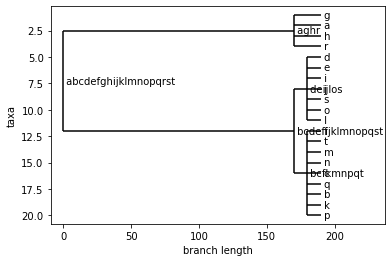

In [24]:
# convert to biopython and plot
tree = apc.alife_dataframe_to_biopython_tree(df_phylogeny, setup_branch_lengths=True)
tree.ladderize()
Phylo.draw(tree)
# note that origin_time isn't set quite correctly (off by one)
